In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataframes of the different component
rooth_path = '../data/'
generator_train = pd.read_csv(rooth_path + 'generator_train.csv')
gen_bear_train = pd.read_csv(rooth_path + 'gen_bear_train.csv')
transformer_train = pd.read_csv(rooth_path + 'transformer_train.csv')
hydraulic_train = pd.read_csv(rooth_path + 'hydraulic_train.csv')
gearbox_train = pd.read_csv(rooth_path + 'gearbox_train.csv')
generator_test = pd.read_csv(rooth_path + 'generator_test.csv')
gen_bear_test = pd.read_csv(rooth_path + 'gen_bear_test.csv')
transformer_test = pd.read_csv(rooth_path + 'transformer_test.csv')
hydraulic_test = pd.read_csv(rooth_path + 'hydraulic_test.csv')
gearbox_test = pd.read_csv(rooth_path + 'gearbox_test.csv')
df_costs = pd.read_csv(rooth_path + 'training/HTW_Costs.csv')

### We are ready to build our base-model for each component. 

- We will need to scale the features, within each turbine
- Since we have a very unbalanced dataset we will use SMOTE for balancing the training data set
- Reach a base line model
- Try other algorithms and fine tune
- Probably we will need to change the threshold to reduce the FP
- Calculate the different costs of our best models

In [3]:
# Scale within each turbine
def scale (df_train, df_test, scaler='StandardScaler'):
    
    '''Scale within each given turbine
    
    Args:
            df_train      : Train datarame
            df_test       : Test dataframe
        
    Returns:
            array         : Scaled array of train and test'''
    
    
    # Scale for turbine T01 first
    X_train1 = df_train.loc[df_train['Turbine_ID']=='T01']
    X_test1 = df_test.loc[df_test['Turbine_ID']=='T01']

    X_train1 = X_train1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    X_test1 = X_test1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    
    if scaler == 'MinMaxScaler':
        sc = MinMaxScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    else:
        sc = StandardScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    
    # Scale on other turbines
    turbines = ['T06', 'T07', 'T09', 'T11']
    for turbine in turbines:
        X_train_ = df_train.loc[df_train['Turbine_ID']==turbine]
        X_test_ = df_test.loc[df_test['Turbine_ID']==turbine]

        X_train_ = X_train_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
        X_test_ = X_test_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])

        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        else:
            sc = StandardScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        
        # Concatenate
        X_train1 = np.concatenate((X_train1, X_train_))
        X_test1 = np.concatenate((X_test1, X_test_))
        
             
    return X_train1, X_test1

In [4]:
# Data augmentation using SMOTE
def data_aug(X_train, y_train):
    
    '''Function for data augmentation, using SMOTE
    
    Args:
            X_train                 : X_train
            y_train                 : y_train
        
    Returns:
            X_train, y_train         : X_train, y_train SMOTE training data '''
    
    
    all_classes = Counter(y_train)
    majority_class = all_classes.most_common(1)
    minority_class = all_classes.most_common()[1:]
    ratio = minority_class[0][1]/majority_class[0][1]
    
    # If ratio of training set < 10% 
    if ratio < 0.1:
        over = SMOTE(sampling_strategy=0.1, random_state=0) # 10% of positive examples
        X_train, y_train = over.fit_sample(X_train, y_train)    
    
    return X_train, y_train

In [5]:
# Function to predict
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
    
    '''Function for Grid Search
    
    Args:
            model (str)            : Model Name
            clf (clfassifierobj)   : Classifier to apply Grid Search
            X_train (series)       : X_train
            X_test (series)        : y_train
            y_train (series)       : X_train
            y_test (series)        : y_train
            params (dict)          : Grid Search parameters
            score (str)            : Grid Search Score
        
    Returns:
            best_estimator, predictions   : best GridSearch estimator, dataframe with y_pred, y_score '''
    
    
    #Grid Search
    grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    
    #Predictions
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [6]:
# Function for metrics
def metrics(estimator, X_test, y_test, y_pred):
    
    '''Function to calculate classification metrics
    
    Args:
            estimator            : Model 
            X_test (series)      : X_test
            y_test (series)      : y_test
            y_pred (series)      : y_pred
        
    Returns: classification report, confusion matrix, roc_auc, Precision-Recall Graph'''
    
    # Classification Report
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print(confusion_matrix(y_test, y_pred))
        
    #Roc Curve
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Precision Recall curve
    precision, recall, treshold = precision_recall_curve(y_test, y_pred)
    
    plt.figure(figsize=(15,5))
    
    # Plot Roc
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label= f'{estimator} AUC = %0.2f'% roc_auc)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
    
    # Plot Decision Recall
    plt.subplot(1,2,2)
    plt.plot(treshold, precision[:-1], c ='r', label ='Precision')
    plt.plot(treshold, recall[:-1], c ='b', label ='Recall')
    plt.xlabel("Treshold")
    plt.ylabel("%")
    plt.grid()
    plt.legend()
    
    plt.show()

In [7]:
# Logistic Regression
def logreg(X_train, X_test, y_train, y_test):
    model = 'Logistic Regression'
    clf_logreg = LogisticRegression(random_state=42, max_iter=3000, n_jobs=-1)
    gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
    gs_score = 'roc_auc'

    clf_logreg, pred_logreg = bin_classify(model, clf_logreg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_logreg)
    
    metrics(clf_logreg, X_test, y_test, pred_logreg['y_pred'])
    
    return clf_logreg, pred_logreg

In [8]:
# Random Forest Classifier
def rfc(X_train, X_test, y_train, y_test):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [10, 20, 50, 100, 500, 750, 800, 1000, 1200], 'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced']}
    gs_score = 'roc_auc'

    clf_rfc, pred_rfc = bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)
    
    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'])
    
    return clf_rfc, pred_rfc

In [9]:
# Gradient Boosting Classifier
def gbc(X_train, X_test, y_train, y_test):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.5, 0.6, 0.8, 1]}
    gs_score = 'roc_auc'

    clf_gbc, pred_gbc = bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'])
    
    return clf_gbc, pred_gbc

In [10]:
# K-Neighbors
def knn(X_train, X_test, y_train, y_test):
    model = 'KNN'
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    gs_params = {'n_neighbors': [3, 5, 7, 10, 15]}
    gs_score = 'roc_auc'

    clf_knn, pred_knn = bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'])
    
    return clf_knn, pred_knn

In [11]:
# Ada Boost Classifier
def abc(X_train, X_test, y_train, y_test):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.01, 0.1, 0.5, 0.6, 1]}
    gs_score = 'roc_auc'

    clf_abc, pred_abc = bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'])
    
    return clf_abc, pred_abc

In [12]:
# SVC
def svc(X_train, X_test, y_train, y_test):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [1,2,3], 'gamma': ['auto', 'scale']}
    gs_score = 'roc_auc'

    clf_svc, pred_svc = bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'])
    
    return clf_svc, pred_svc

In [13]:
# Naive Bayes
def gnb(X_train, X_test, y_train, y_test):
    model = 'Gaussian NB'
    clf_gnb = GaussianNB()
    gs_params = {}
    gs_score = 'roc_auc'

    clf_gnb, pred_gnb = bin_classify(model, clf_gnb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gnb)

    metrics(clf_gnb, X_test, y_test, pred_gnb['y_pred'])
    
    return clf_gnb, pred_gnb

In [14]:
# Decision Trees
def dtc(X_train, X_test, y_train, y_test):
    model = 'Decision Tree'
    clf_dtc = DecisionTreeClassifier(random_state=42)
    gs_params = {'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced']}
    gs_score = 'roc_auc'

    clf_dtc, pred_dtc = bin_classify(model, clf_dtc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_dtc)

    metrics(clf_dtc, X_test, y_test, pred_dtc['y_pred'])
    
    return clf_dtc, pred_dtc

# 1st Analysis - Base Models

## GENERATOR

In [15]:
# By exploration, drop columns:
gen_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 
                'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd', 
                'Gen_Phase2_Temp_Avg', 'Gen_Phase2_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_sd', 
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_InverterPhase1_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg_av', 'Grd_InverterPhase1_Temp_Avg_sd']

In [16]:
# Drop columns
generator_train_ = generator_train.drop(columns = gen_col_drop)
generator_test_ = generator_test.drop(columns = gen_col_drop)

In [17]:
# Scale
X_train_gen, X_test_gen = scale(generator_train_, generator_test_)

In [18]:
# Define target and Data Augmentation on training data
y_train_gen = generator_train['Failure']
y_test_gen = generator_test['Failure']
X_train_gen, y_train_gen = data_aug(X_train_gen, y_train_gen)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.78      1220
   macro avg       0.47      0.41      0.44      1220
weighted avg       0.90      0.78      0.83      1220

[[947 214]
 [ 59   0]]


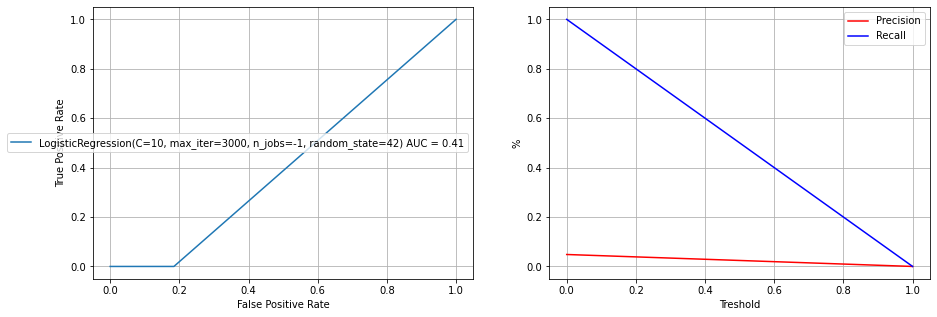


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.94      1220
   macro avg       0.48      0.49      0.48      1220
weighted avg       0.91      0.94      0.92      1220

[[1147   14]
 [  59    0]]


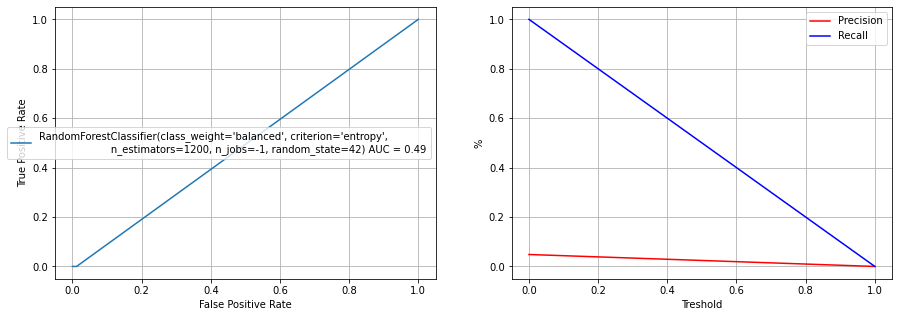


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1161
           1       0.83      0.75      0.79        59

    accuracy                           0.98      1220
   macro avg       0.91      0.87      0.89      1220
weighted avg       0.98      0.98      0.98      1220

[[1152    9]
 [  15   44]]


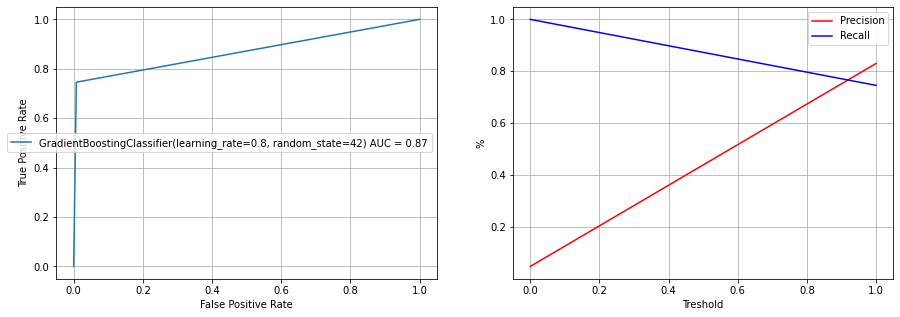


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.93      1220
   macro avg       0.48      0.49      0.48      1220
weighted avg       0.90      0.93      0.91      1220

[[1129   32]
 [  59    0]]


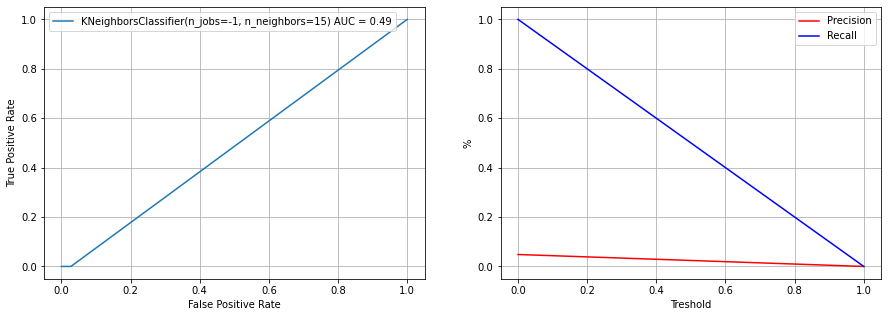


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.91      1220
   macro avg       0.47      0.48      0.48      1220
weighted avg       0.90      0.91      0.91      1220

[[1108   53]
 [  59    0]]


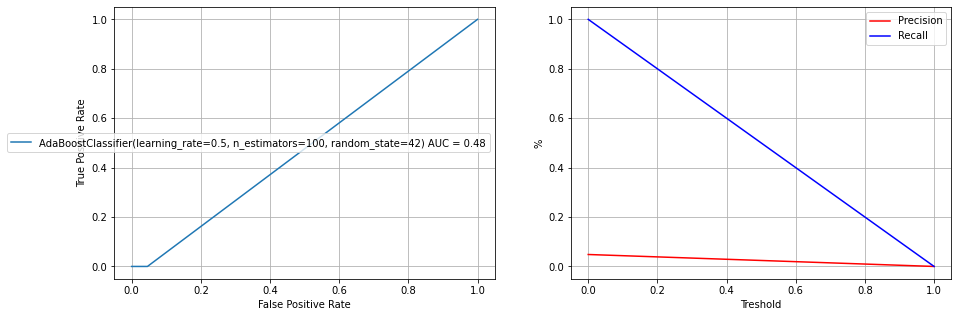


Best Parameters:
 SVC(C=1.2, degree=1, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.79      1220
   macro avg       0.47      0.42      0.44      1220
weighted avg       0.90      0.79      0.84      1220

[[967 194]
 [ 59   0]]


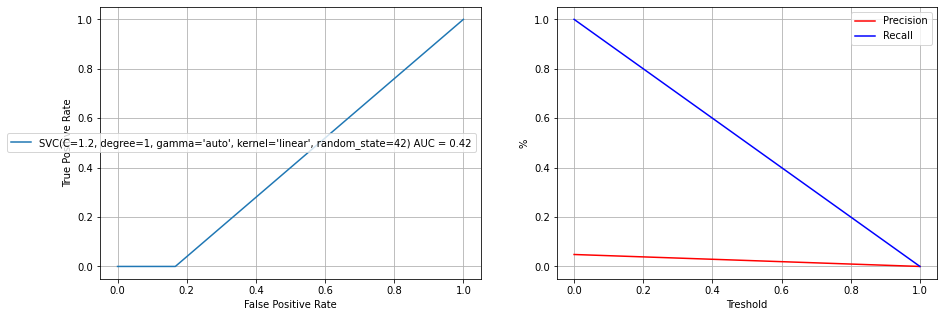


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.72      1220
   macro avg       0.47      0.38      0.42      1220
weighted avg       0.89      0.72      0.80      1220

[[877 284]
 [ 59   0]]


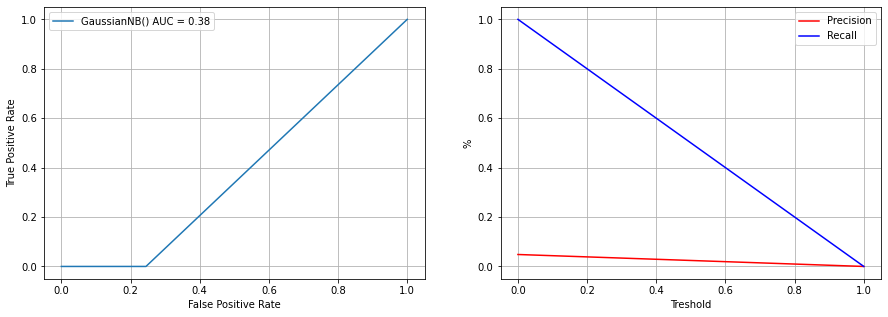


Best Parameters:
 DecisionTreeClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1161
           1       0.55      0.61      0.58        59

    accuracy                           0.96      1220
   macro avg       0.76      0.79      0.78      1220
weighted avg       0.96      0.96      0.96      1220

[[1131   30]
 [  23   36]]


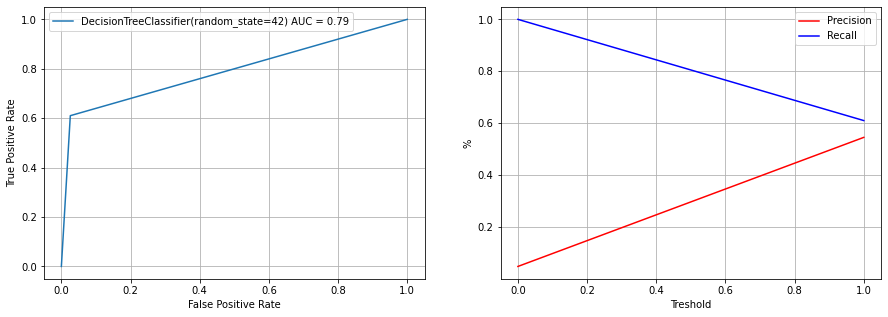

In [19]:
clf_logreg_gen, pred_logreg_gen = logreg(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_rfc_gen, pred_rfc_gen = rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gbc_gen, pred_gbc_gen = gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_knn_gen, pred_knn_gen = knn(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_abc_gen, pred_abc_gen = abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_svc_gen, pred_svc_gen = svc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gnb_gen, pred_gnb_gen = gnb(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_dtc_gen, pred_dtc_gen = dtc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)

## GENERATOR BEARING

In [20]:
# By exploration, drop columns:
bear_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 
                'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd', 
                'Gen_Phase2_Temp_Avg', 'Gen_Phase2_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_sd', 
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                 'Grd_InverterPhase1_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg_av', 'Grd_InverterPhase1_Temp_Avg_sd']

In [21]:
# Drop columns
gen_bear_train_ = gen_bear_train.drop(columns = bear_col_drop)
gen_bear_test_ = gen_bear_test.drop(columns = bear_col_drop)

In [22]:
# Scale
X_train_bear, X_test_bear = scale(gen_bear_train_, gen_bear_test_)

In [23]:
# Define target and Data Augmentation on training data
y_train_bear = gen_bear_train['Failure']
y_test_bear = gen_bear_test['Failure']
X_train_bear, y_train_bear = data_aug(X_train_bear, y_train_bear)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.90      0.62      0.74      1138
           1       0.01      0.07      0.02        82

    accuracy                           0.59      1220
   macro avg       0.46      0.35      0.38      1220
weighted avg       0.84      0.59      0.69      1220

[[711 427]
 [ 76   6]]


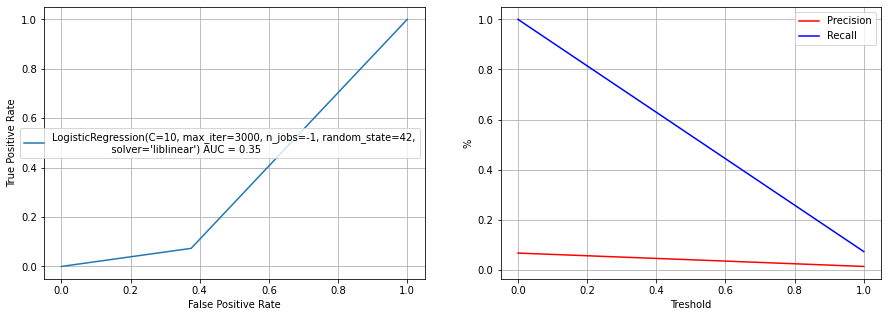


Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=10, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


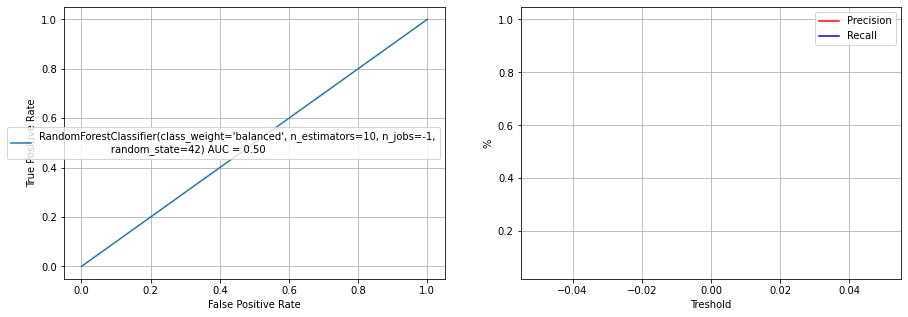


Best Parameters:
 GradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1138
           1       0.01      0.02      0.02        82

    accuracy                           0.82      1220
   macro avg       0.47      0.45      0.46      1220
weighted avg       0.86      0.82      0.84      1220

[[999 139]
 [ 80   2]]


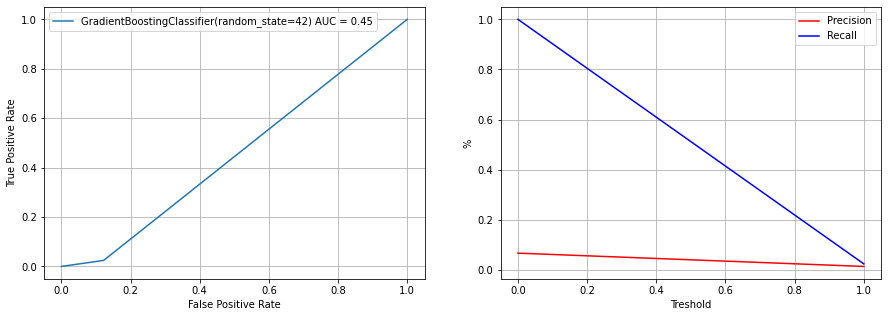


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1138
           1       0.07      0.07      0.07        82

    accuracy                           0.87      1220
   macro avg       0.50      0.50      0.50      1220
weighted avg       0.87      0.87      0.87      1220

[[1054   84]
 [  76    6]]


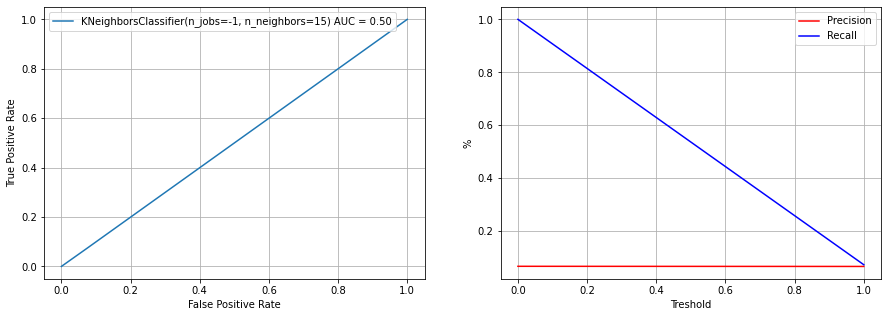


Best Parameters:
 AdaBoostClassifier(learning_rate=0.6, n_estimators=10, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1138
           1       0.11      0.16      0.13        82

    accuracy                           0.86      1220
   macro avg       0.52      0.53      0.53      1220
weighted avg       0.88      0.86      0.87      1220

[[1034  104]
 [  69   13]]


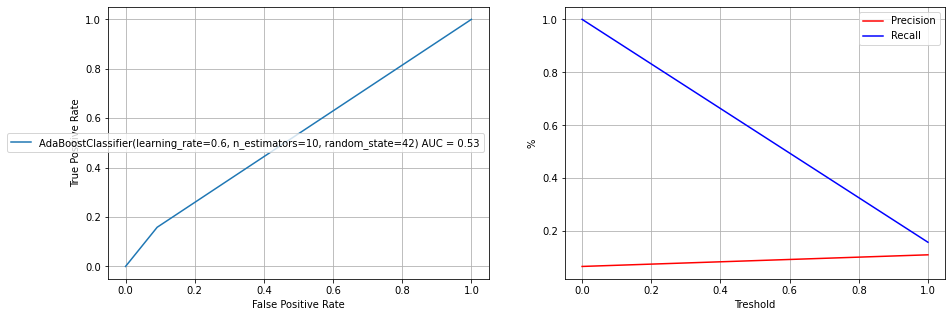


Best Parameters:
 SVC(C=0.01, degree=2, kernel='poly', random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


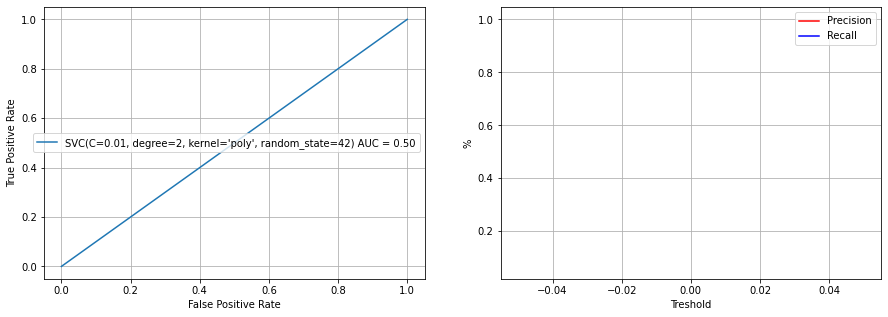


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.77      1220
   macro avg       0.46      0.41      0.43      1220
weighted avg       0.86      0.77      0.81      1220

[[937 201]
 [ 82   0]]


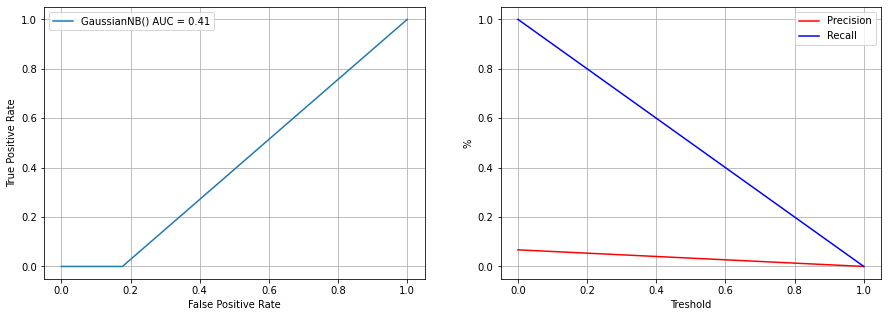


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', random_state=42)
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1138
           1       0.02      0.04      0.02        82

    accuracy                           0.78      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.86      0.78      0.82      1220

[[944 194]
 [ 79   3]]


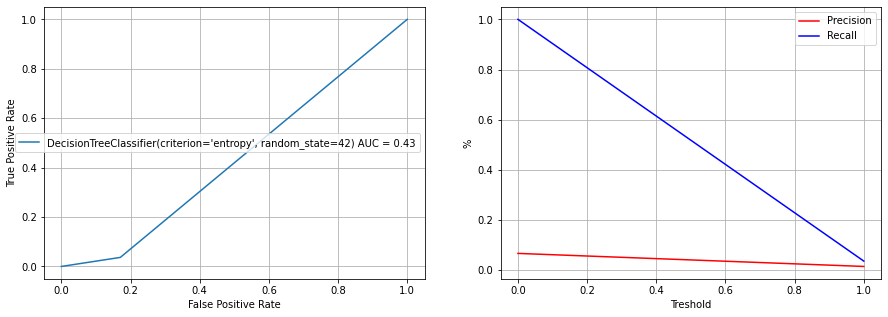

In [24]:
clf_logreg_bear, pred_logreg_bear = logreg(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_rfc_bear, pred_rfc_bear = rfc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gbc_bear, pred_gbc_bear = gbc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_knn_bear, pred_knn_bear = knn(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_abc_bear, pred_abc_bear = abc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_svc_bear, pred_svc_bear = svc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gnb_bear, pred_gnb_bear = gnb(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_dtc_bear, pred_dtc_bear = dtc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)

## TRANSFORMER

In [25]:
# By exploration, drop columns:
transf_col_drop = ['HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase2_Temp_Avg_sd', 
                   'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                   'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                   'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                   'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                   'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                   'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                   'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                   'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [26]:
# Drop columns
transformer_train_ = transformer_train.drop(columns = transf_col_drop)
transformer_test_ = transformer_test.drop(columns = transf_col_drop)

In [27]:
# Scale
X_train_transf, X_test_transf = scale(transformer_train_, transformer_test_)

In [28]:
# Define target and Data Augmentation on training data
y_train_transf = transformer_train['Failure']
y_test_transf = transformer_test['Failure']
X_train_transf, y_train_transf = data_aug(X_train_transf, y_train_transf)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1161
           1       0.10      0.32      0.15        59

    accuracy                           0.82      1220
   macro avg       0.53      0.59      0.53      1220
weighted avg       0.92      0.82      0.87      1220

[[987 174]
 [ 40  19]]


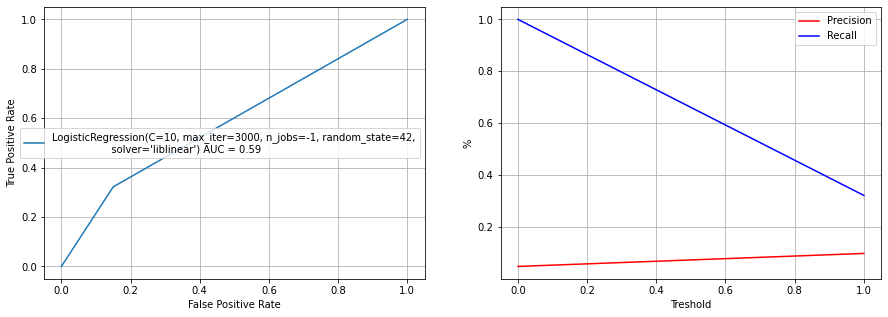


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


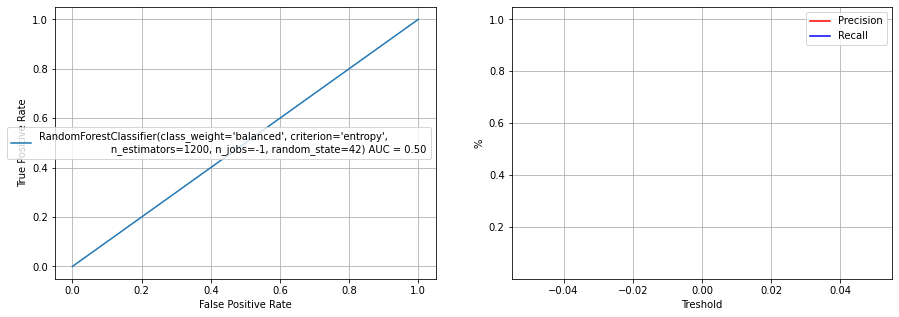


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1161
           1       0.01      0.05      0.02        59

    accuracy                           0.74      1220
   macro avg       0.48      0.41      0.43      1220
weighted avg       0.90      0.74      0.81      1220

[[897 264]
 [ 56   3]]


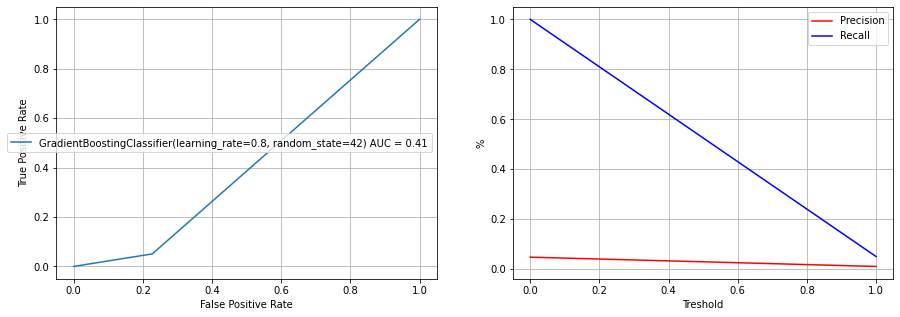


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1161
           1       0.02      0.02      0.02        59

    accuracy                           0.92      1220
   macro avg       0.49      0.49      0.49      1220
weighted avg       0.91      0.92      0.91      1220

[[1120   41]
 [  58    1]]


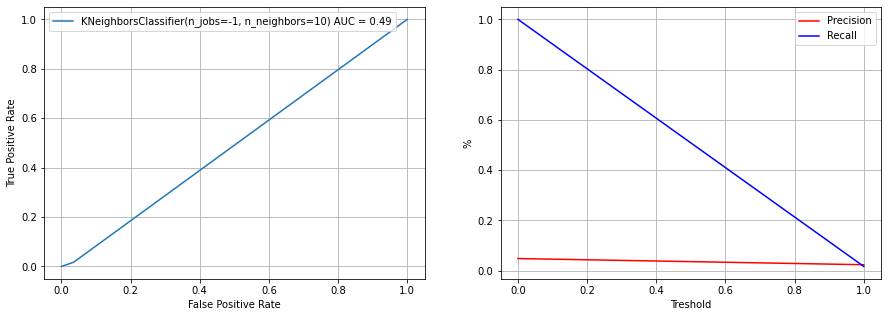


Best Parameters:
 AdaBoostClassifier(learning_rate=0.6, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1161
           1       0.02      0.05      0.03        59

    accuracy                           0.83      1220
   macro avg       0.48      0.46      0.47      1220
weighted avg       0.90      0.83      0.86      1220

[[1004  157]
 [  56    3]]


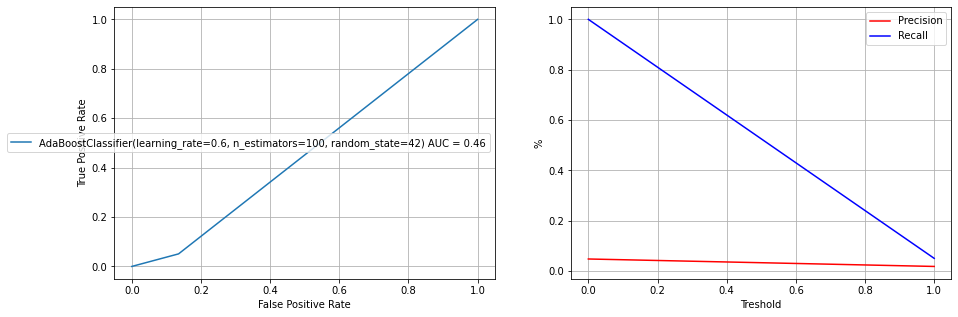


Best Parameters:
 SVC(C=1.2, degree=1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


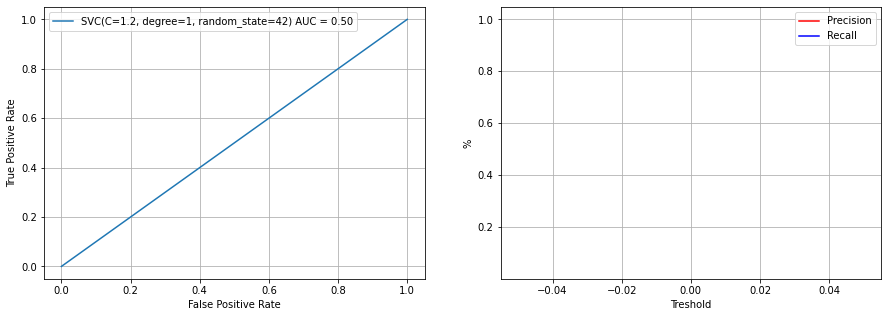


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1161
           1       0.14      0.85      0.24        59

    accuracy                           0.74      1220
   macro avg       0.56      0.79      0.54      1220
weighted avg       0.95      0.74      0.81      1220

[[850 311]
 [  9  50]]


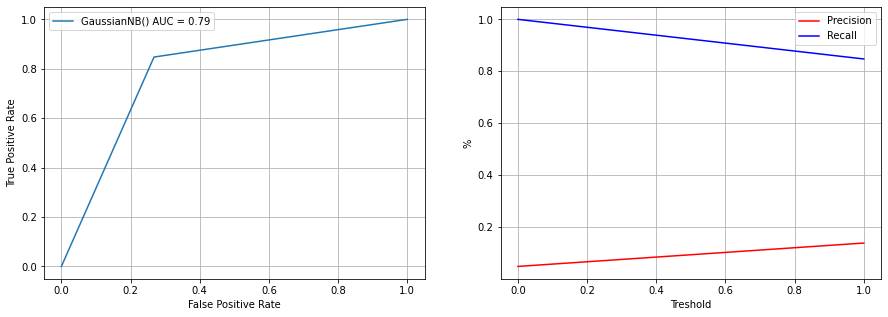


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.87      1220
   macro avg       0.47      0.45      0.46      1220
weighted avg       0.90      0.87      0.88      1220

[[1056  105]
 [  59    0]]


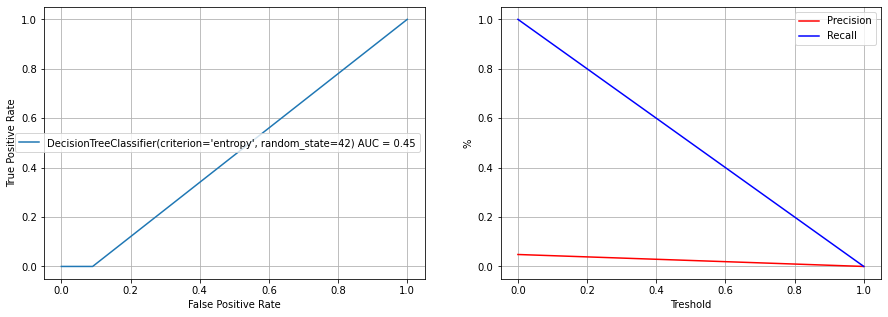

In [29]:
clf_logreg_transf, pred_logreg_transf = logreg(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_rfc_transf, pred_rfc_transf = rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gbc_transf, pred_gbc_transf = gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_knn_transf, pred_knn_transf = knn(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_abc_transf, pred_abc_transf = abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_svc_transf, pred_svc_transf = svc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gnb_transf, pred_gnb_transf = gnb(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_dtc_transf, pred_dtc_transf = dtc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)

## HYDRAULIC

In [30]:
# By exploration, drop columns:
hyd_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [31]:
# Drop columns
hydraulic_train_ = hydraulic_train.drop(columns = hyd_col_drop)
hydraulic_test_ = hydraulic_test.drop(columns = hyd_col_drop)

In [32]:
# Scale
X_train_hyd, X_test_hyd = scale(hydraulic_train_, hydraulic_test_)

In [33]:
# Define target and Data Augmentation on training data
y_train_hyd = hydraulic_train['Failure']
y_test_hyd = hydraulic_test['Failure']
X_train_hyd, y_train_hyd = data_aug(X_train_hyd, y_train_hyd)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1043
           1       0.24      0.20      0.22       177

    accuracy                           0.80      1220
   macro avg       0.56      0.55      0.55      1220
weighted avg       0.78      0.80      0.79      1220

[[935 108]
 [142  35]]


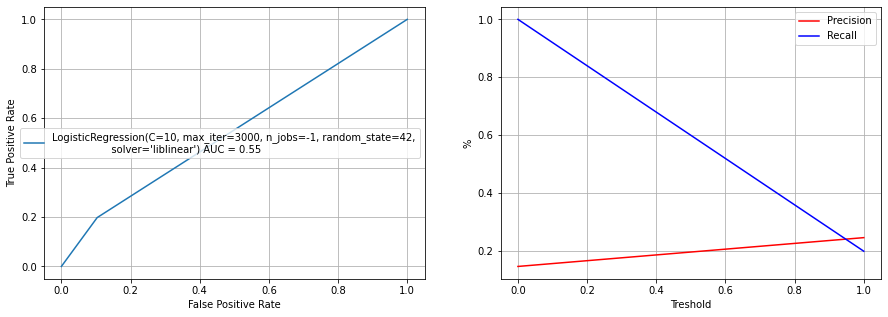


Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=1200, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.85      1220
   macro avg       0.43      0.50      0.46      1220
weighted avg       0.73      0.85      0.79      1220

[[1043    0]
 [ 177    0]]


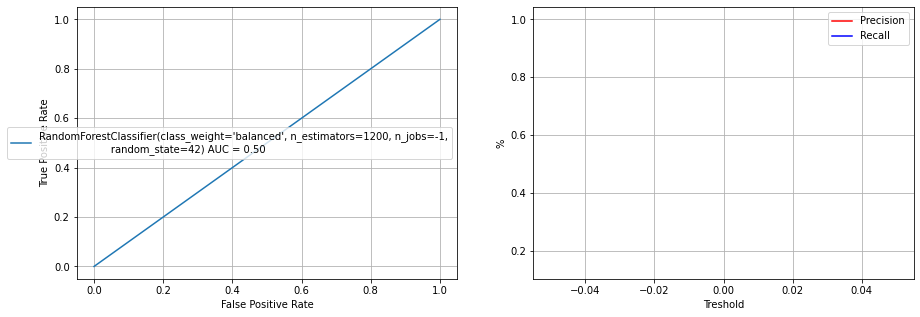


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1043
           1       0.42      0.12      0.19       177

    accuracy                           0.85      1220
   macro avg       0.65      0.55      0.55      1220
weighted avg       0.80      0.85      0.81      1220

[[1013   30]
 [ 155   22]]


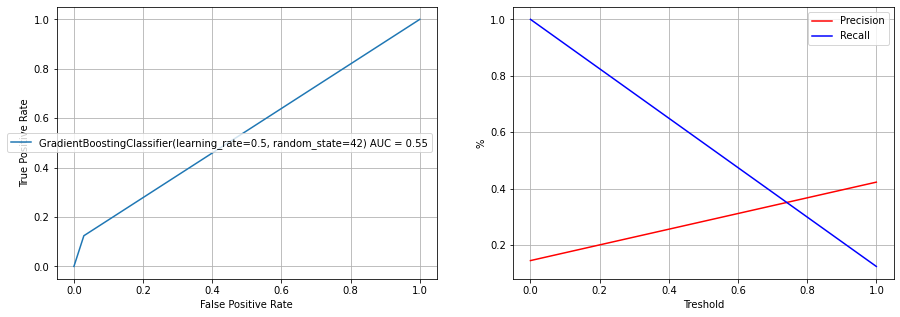


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1043
           1       0.14      0.15      0.14       177

    accuracy                           0.74      1220
   macro avg       0.49      0.49      0.49      1220
weighted avg       0.75      0.74      0.74      1220

[[872 171]
 [150  27]]


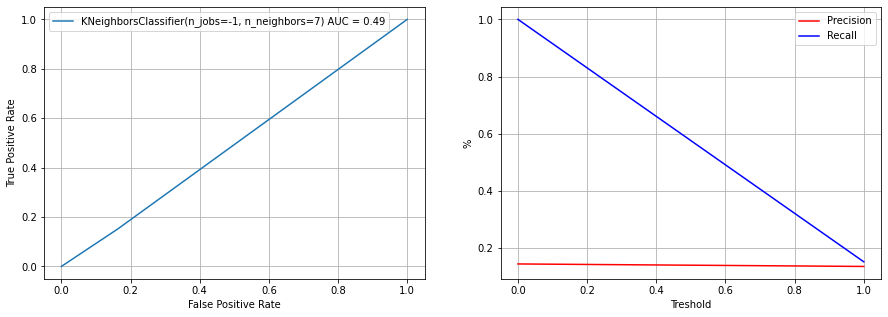


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1043
           1       0.17      0.05      0.07       177

    accuracy                           0.83      1220
   macro avg       0.51      0.50      0.49      1220
weighted avg       0.76      0.83      0.79      1220

[[1004   39]
 [ 169    8]]


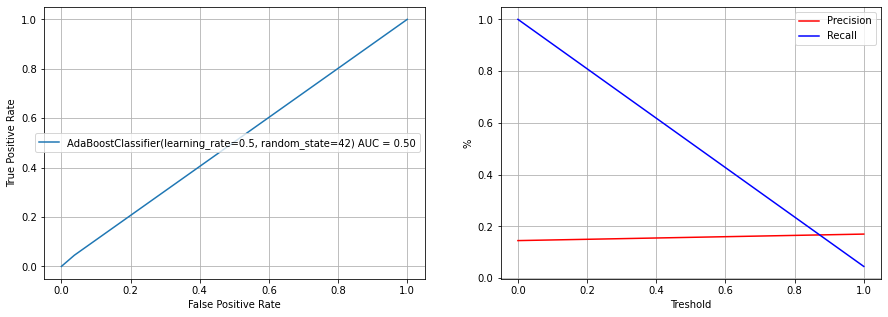


Best Parameters:
 SVC(C=1.2, degree=1, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1043
           1       0.22      0.20      0.21       177

    accuracy                           0.78      1220
   macro avg       0.54      0.54      0.54      1220
weighted avg       0.77      0.78      0.78      1220

[[914 129]
 [141  36]]


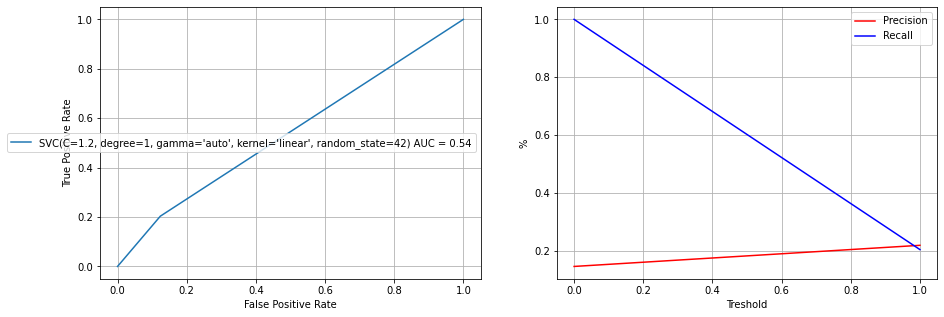


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1043
           1       0.28      0.37      0.32       177

    accuracy                           0.77      1220
   macro avg       0.58      0.60      0.59      1220
weighted avg       0.80      0.77      0.78      1220

[[878 165]
 [112  65]]


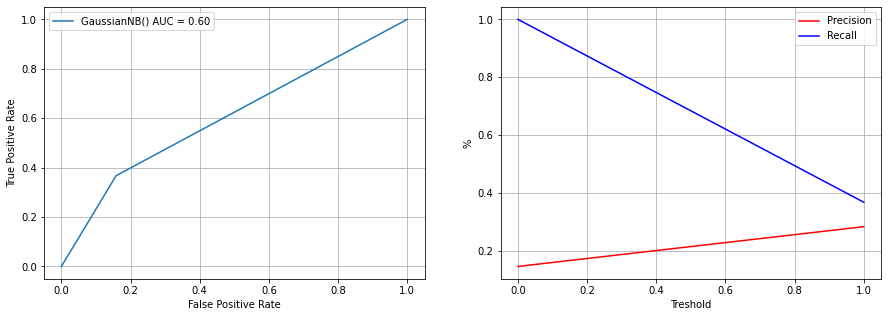


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', random_state=42)
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1043
           1       0.22      0.10      0.13       177

    accuracy                           0.82      1220
   macro avg       0.54      0.52      0.52      1220
weighted avg       0.77      0.82      0.79      1220

[[983  60]
 [160  17]]


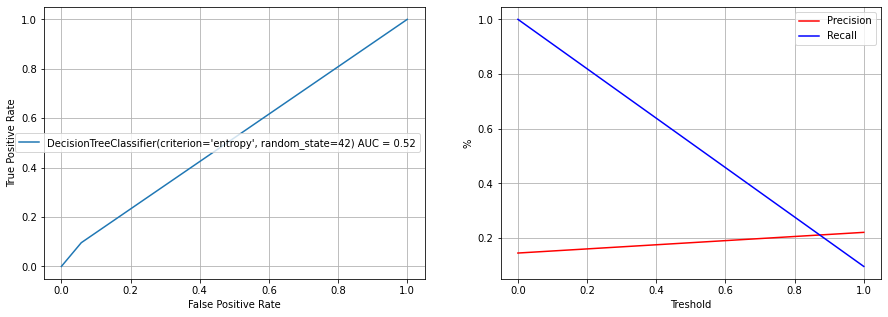

In [34]:
clf_logreg_hyd, pred_logreg_hyd = logreg(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_rfc_hyd, pred_rfc_hyd = rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gbc_hyd, pred_gbc_hyd = gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_knn_hyd, pred_knn_hyd = knn(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_abc_hyd, pred_abc_hyd = abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_svc_hyd, pred_svc_hyd = svc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gnb_hyd, pred_gnb_hyd = gnb(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_dtc_hyd, pred_dtc_hyd = dtc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)

## GEARBOX

In [35]:
# By exploration, drop columns:
gear_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [36]:
# Drop columns
gearbox_train_ = gearbox_train.drop(columns = gear_col_drop)
gearbox_test_ = gearbox_test.drop(columns = gear_col_drop)

In [37]:
# Scale
X_train_gear, X_test_gear = scale(gearbox_train_, gearbox_test_)

In [38]:
# Define target and Data Augmentation on training data
y_train_gear = gearbox_train['Failure']
y_test_gear = gearbox_test['Failure']
X_train_gear, y_train_gear = data_aug(X_train_gear, y_train_gear)


Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.87      1212
   macro avg       0.47      0.46      0.47      1212
weighted avg       0.90      0.87      0.89      1212

[[1056   97]
 [  59    0]]


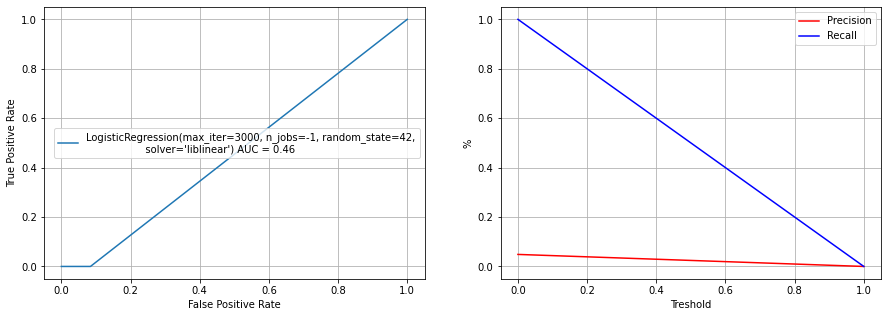


Best Parameters:
 RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


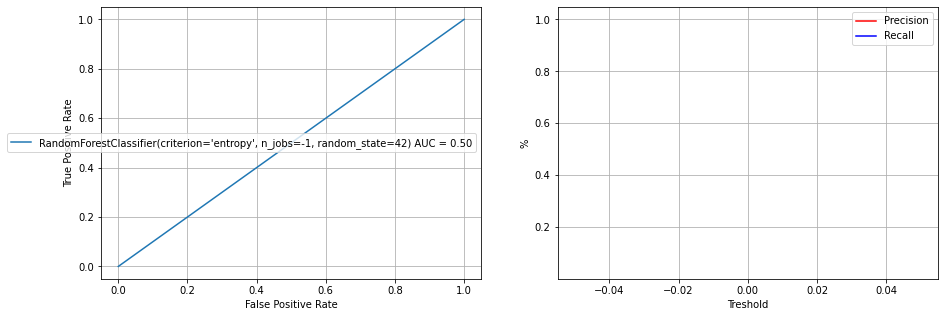


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.6, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1153
           1       0.10      0.20      0.13        59

    accuracy                           0.87      1212
   macro avg       0.53      0.55      0.53      1212
weighted avg       0.92      0.87      0.89      1212

[[1045  108]
 [  47   12]]


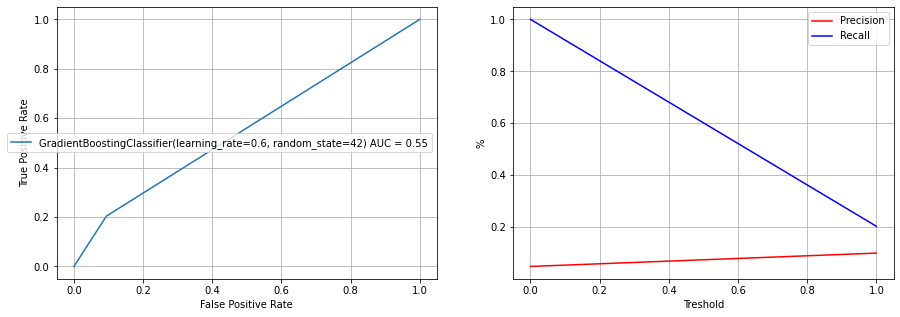


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1153
           1       0.21      0.27      0.24        59

    accuracy                           0.92      1212
   macro avg       0.59      0.61      0.60      1212
weighted avg       0.93      0.92      0.92      1212

[[1094   59]
 [  43   16]]


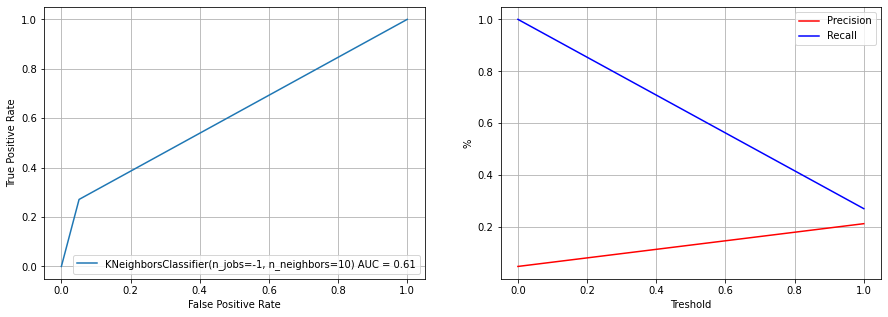


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.90      0.95      0.93      1212

[[1147    6]
 [  59    0]]


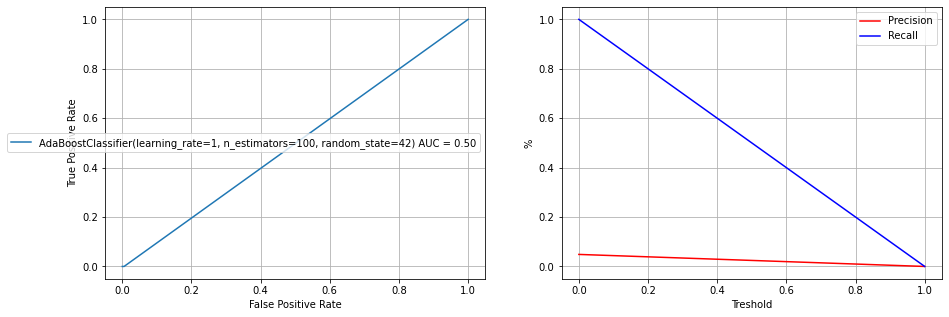


Best Parameters:
 SVC(C=1.2, degree=1, gamma='auto', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1153
           1       0.07      0.05      0.06        59

    accuracy                           0.92      1212
   macro avg       0.51      0.51      0.51      1212
weighted avg       0.91      0.92      0.92      1212

[[1116   37]
 [  56    3]]


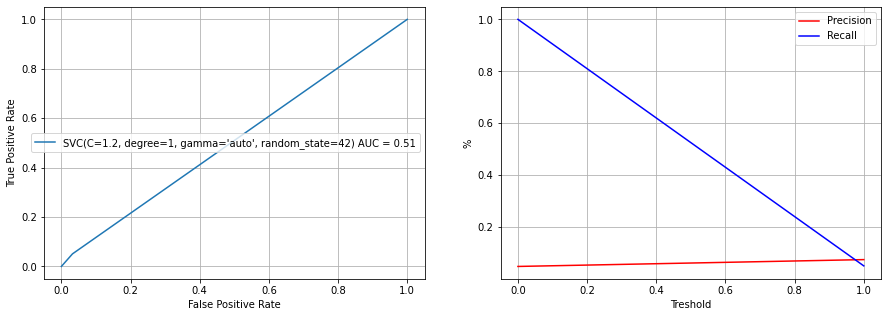


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.91      1212
   macro avg       0.47      0.48      0.48      1212
weighted avg       0.90      0.91      0.91      1212

[[1101   52]
 [  59    0]]


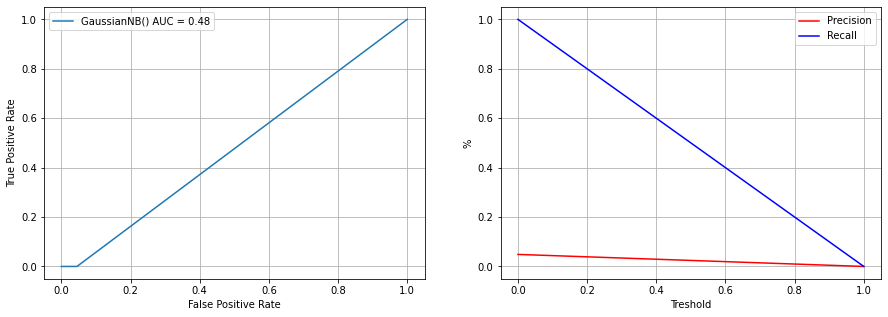


Best Parameters:
 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.90      0.95      0.92      1212

[[1146    7]
 [  59    0]]


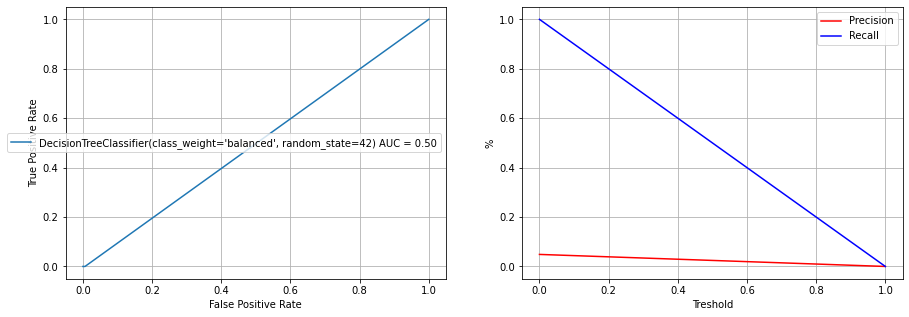

In [39]:
clf_logreg_gear, pred_logreg_gear = logreg(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_rfc_gear, pred_rfc_gear = rfc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gbc_gear, pred_gbc_gear = gbc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_knn_gear, pred_knn_gear = knn(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_abc_gear, pred_abc_gear = abc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_svc_gear, pred_svc_gear = svc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gnb_gear, pred_gnb_gear = gnb(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_dtc_gear, pred_dtc_gear = dtc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)

### Our models are not good

# 2nd Analysis - Try improvements

##### Let's see if we can improve our models just by choosing ONLY the input features for each component

## GENERATOR

In [40]:
generator_train_2 = generator_train[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                    'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                    'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                    'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                    'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd',
                                    'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                    'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]
generator_test_2 = generator_test[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                    'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                    'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                    'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                    'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd',
                                    'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                    'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]

In [41]:
# Scale
X_train_gen_2, X_test_gen_2 = scale(generator_train_2, generator_test_2)

In [42]:
# Define target and Data Augmentation on training data
y_train_gen_2 = generator_train['Failure']
y_test_gen_2 = generator_test['Failure']
X_train_gen_2, y_train_gen_2 = data_aug(X_train_gen_2, y_train_gen_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.81      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.90      0.81      0.85      1220

[[988 173]
 [ 59   0]]


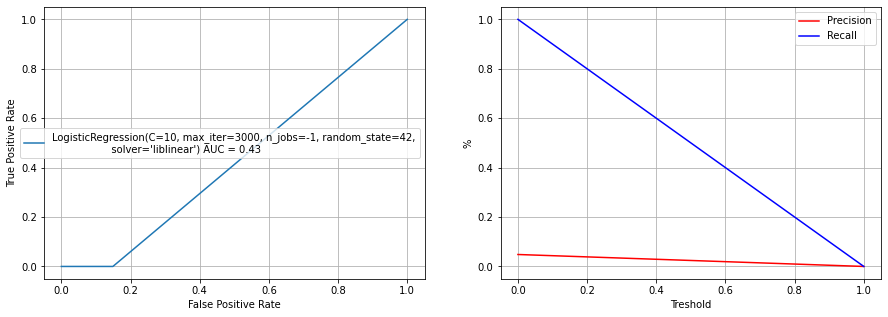


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1157    4]
 [  59    0]]


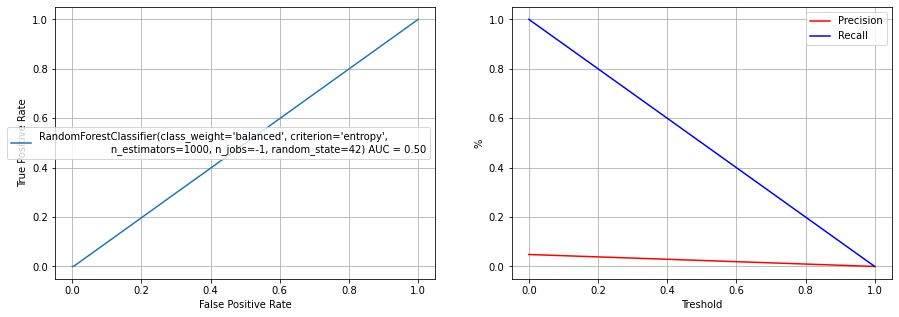


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1161
           1       0.95      0.61      0.74        59

    accuracy                           0.98      1220
   macro avg       0.96      0.80      0.87      1220
weighted avg       0.98      0.98      0.98      1220

[[1159    2]
 [  23   36]]


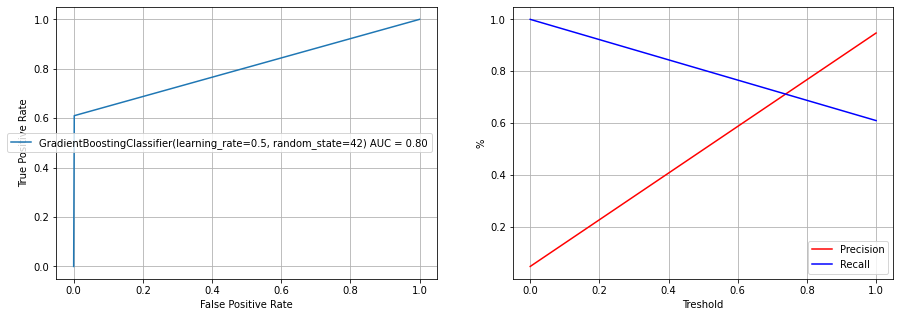


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.08      0.02      0.03        59

    accuracy                           0.94      1220
   macro avg       0.51      0.50      0.50      1220
weighted avg       0.91      0.94      0.92      1220

[[1149   12]
 [  58    1]]


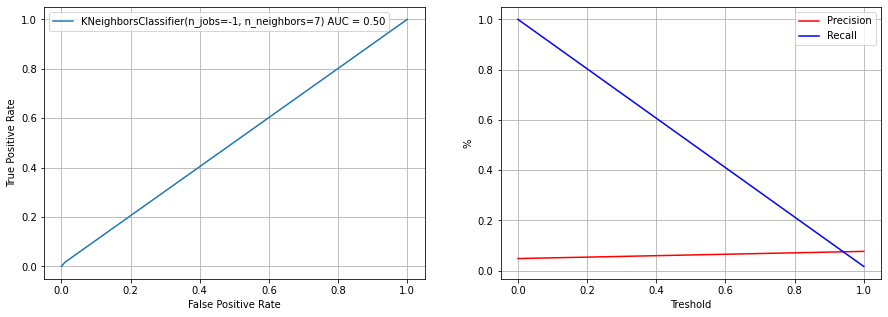


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=20, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  59    0]]


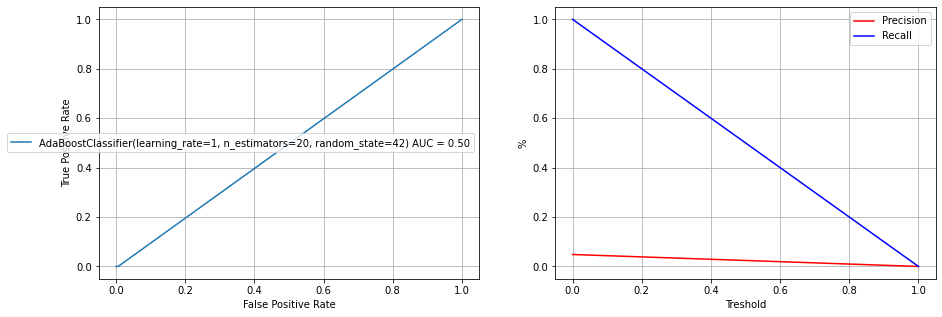


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='poly', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  59    0]]


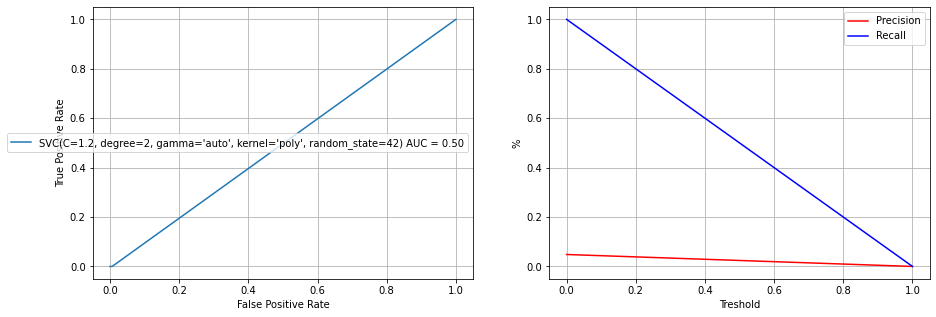


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1161
           1       0.13      0.64      0.21        59

    accuracy                           0.77      1220
   macro avg       0.55      0.71      0.54      1220
weighted avg       0.94      0.77      0.83      1220

[[899 262]
 [ 21  38]]


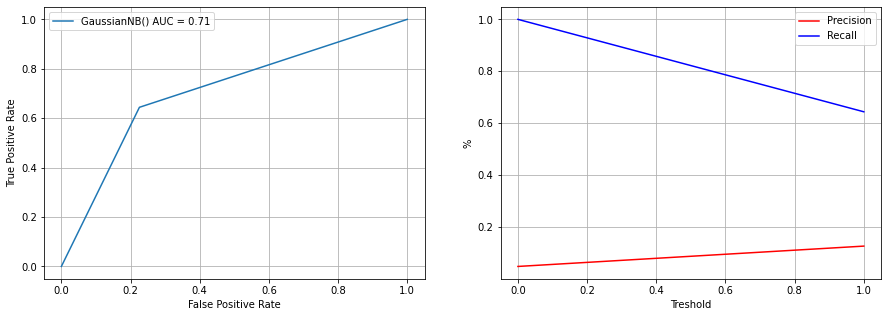


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1161
           1       0.60      0.92      0.72        59

    accuracy                           0.97      1220
   macro avg       0.80      0.94      0.85      1220
weighted avg       0.98      0.97      0.97      1220

[[1125   36]
 [   5   54]]


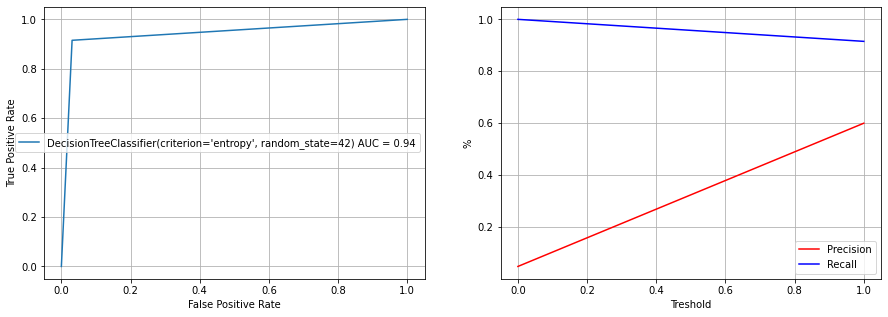

In [43]:
clf_logreg_gen_2, pred_logreg_gen_2 = logreg(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_rfc_gen_2, pred_rfc_gen_2 = rfc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gbc_gen_2, pred_gbc_gen_2 = gbc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_knn_gen_2, pred_knn_gen_2 = knn(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_abc_gen_2, pred_abc_gen_2 = abc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_svc_gen_2, pred_svc_gen_2 = svc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gnb_gen_2, pred_gnb_gen_2 = gnb(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_dtc_gen_2, pred_dtc_gen_2 = dtc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)

## GENERATOR BEARING

In [44]:
gen_bear_train_2 = gen_bear_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd',
                                  'Gen_Bear2_Temp_Avg_sd']]
gen_bear_test_2 = gen_bear_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd',
                                  'Gen_Bear2_Temp_Avg_sd']]

In [45]:
# Scale
X_train_bear_2, X_test_bear_2 = scale(gen_bear_train_2, gen_bear_test_2)
# X_train_bear_2 = gen_bear_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_bear_2 = gen_bear_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [46]:
# Define target and Data Augmentation on training data
y_train_bear_2 = gen_bear_train['Failure']
y_test_bear_2 = gen_bear_test['Failure']
X_train_bear_2, y_train_bear_2 = data_aug(X_train_bear_2, y_train_bear_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1138
           1       0.07      0.09      0.08        82

    accuracy                           0.86      1220
   macro avg       0.50      0.50      0.50      1220
weighted avg       0.87      0.86      0.87      1220

[[1043   95]
 [  75    7]]


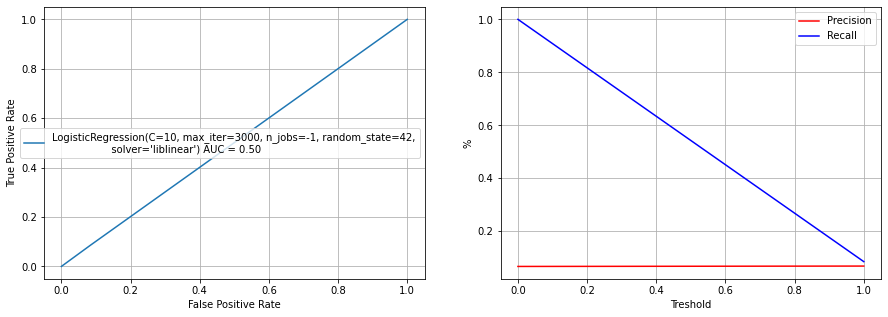


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.85      1220
   macro avg       0.46      0.46      0.46      1220
weighted avg       0.86      0.85      0.86      1220

[[1039   99]
 [  82    0]]


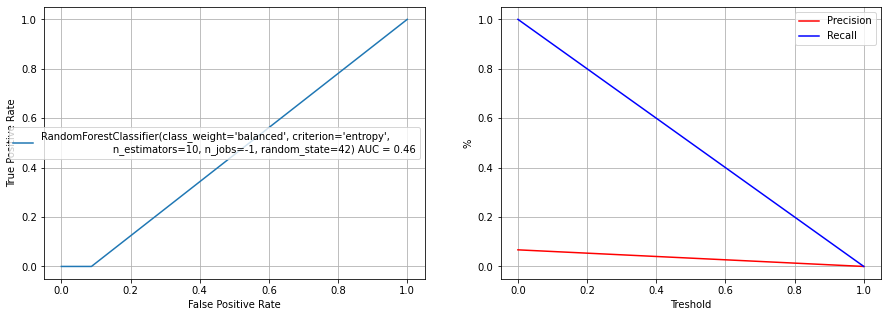


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=50, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1138
           1       0.04      0.07      0.05        82

    accuracy                           0.81      1220
   macro avg       0.48      0.47      0.47      1220
weighted avg       0.87      0.81      0.84      1220

[[985 153]
 [ 76   6]]


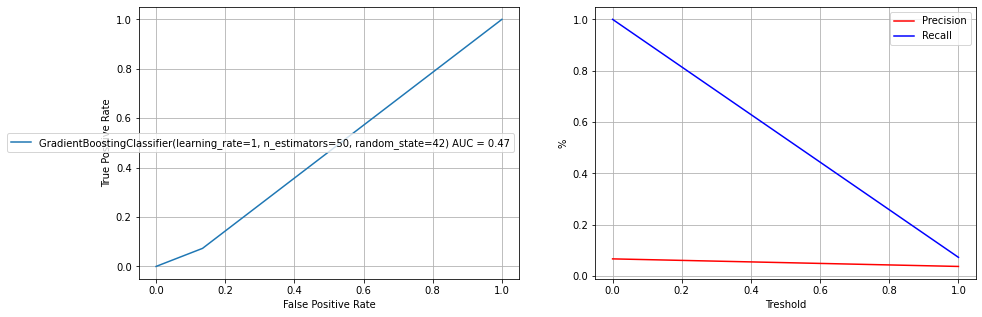


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1138
           1       0.01      0.02      0.02        82

    accuracy                           0.79      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.86      0.79      0.82      1220

[[962 176]
 [ 80   2]]


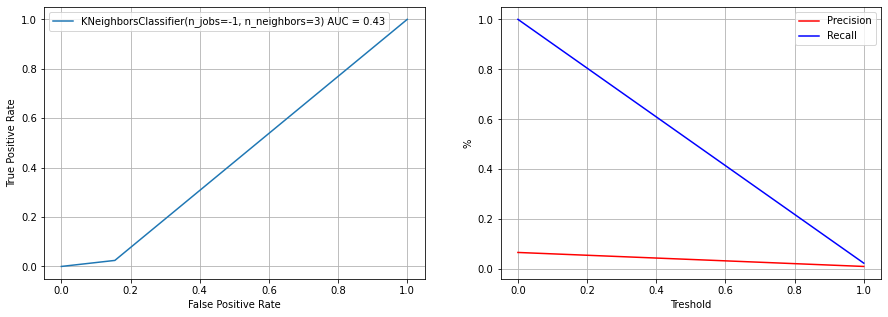


Best Parameters:
 AdaBoostClassifier(learning_rate=0.6, n_estimators=20, random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


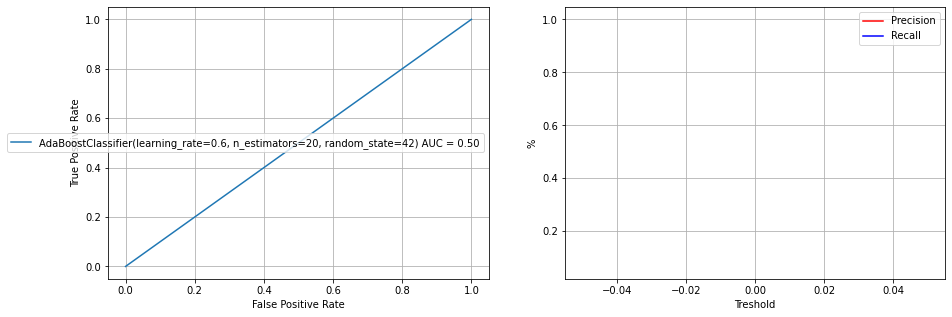


Best Parameters:
 SVC(C=1.2, degree=1, gamma='auto', kernel='poly', random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


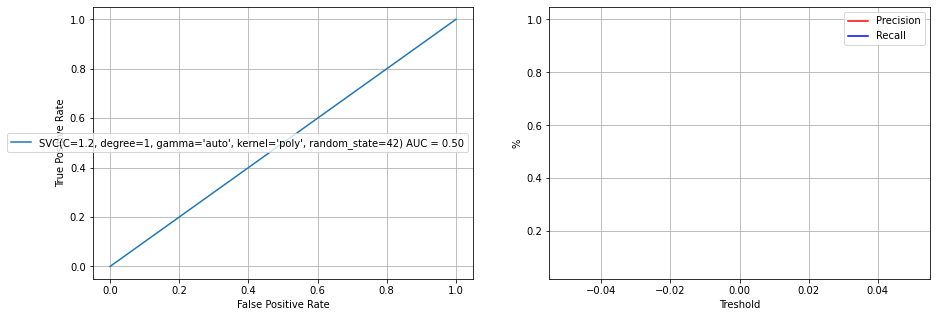


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


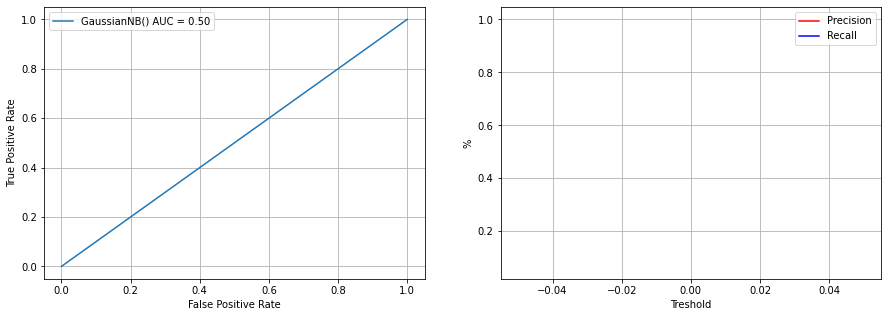


Best Parameters:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.79      1220
   macro avg       0.46      0.42      0.44      1220
weighted avg       0.86      0.79      0.82      1220

[[962 176]
 [ 82   0]]


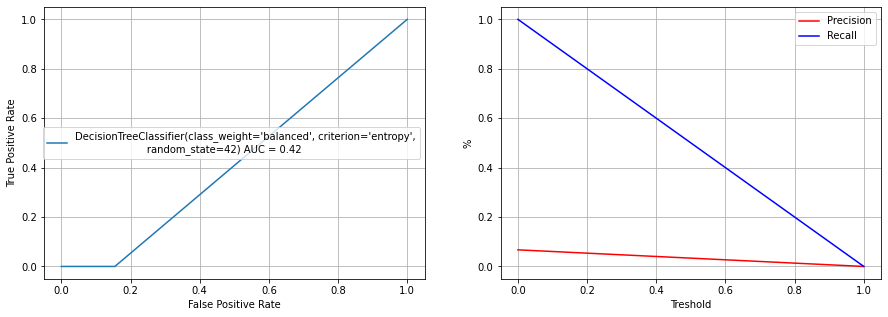

In [47]:
clf_logreg_bear_2, pred_logreg_bear_2 = logreg(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_rfc_bear_2, pred_rfc_bear_2 = rfc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gbc_bear_2, pred_gbc_bear_2 = gbc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_knn_bear_2, pred_knn_bear_2 = knn(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_abc_bear_2, pred_abc_bear_2 = abc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_svc_bear_2, pred_svc_bear_2 = svc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gnb_bear_2, pred_gnb_bear_2 = gnb(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_dtc_bear_2, pred_dtc_bear_2 = dtc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)

## TRANSFORMER

In [48]:
transformer_train_2 = transformer_train[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 
                                        'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av',
                                        'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                                        'HVTrafo_Phase2_Temp_Avg_sd', 'HVTrafo_Phase3_Temp_Avg_sd']]
transformer_test_2 = transformer_test[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 
                                        'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av',
                                        'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                                        'HVTrafo_Phase2_Temp_Avg_sd', 'HVTrafo_Phase3_Temp_Avg_sd']]

In [49]:
# Scale
#X_train_transf_2, X_test_transf_2 = scale(transformer_train_2, transformer_test_2)
X_train_transf_2 = transformer_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
X_test_transf_2 = transformer_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [50]:
# Define target and Data Augmentation on training data
y_train_transf_2 = transformer_train['Failure']
y_test_transf_2 = transformer_test['Failure']
X_train_transf_2, y_train_transf_2 = data_aug(X_train_transf_2, y_train_transf_2)


Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


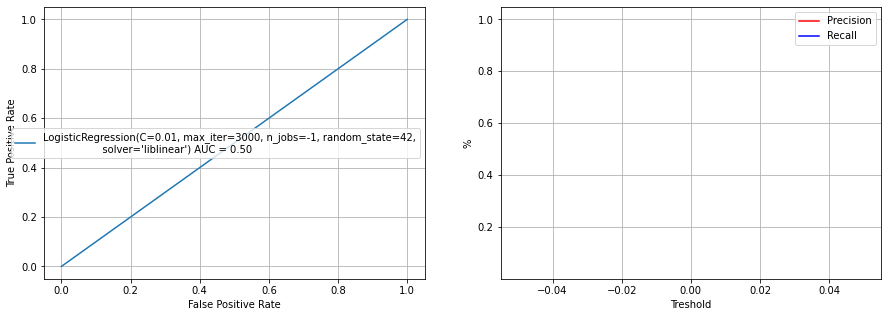


Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


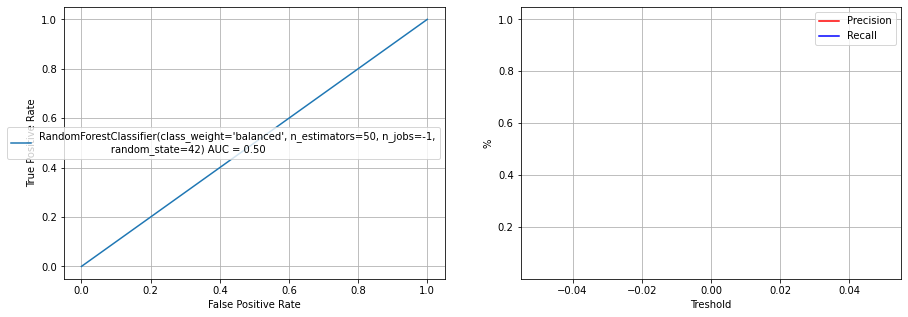


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1161
           1       0.24      0.10      0.14        59

    accuracy                           0.94      1220
   macro avg       0.60      0.54      0.56      1220
weighted avg       0.92      0.94      0.93      1220

[[1142   19]
 [  53    6]]


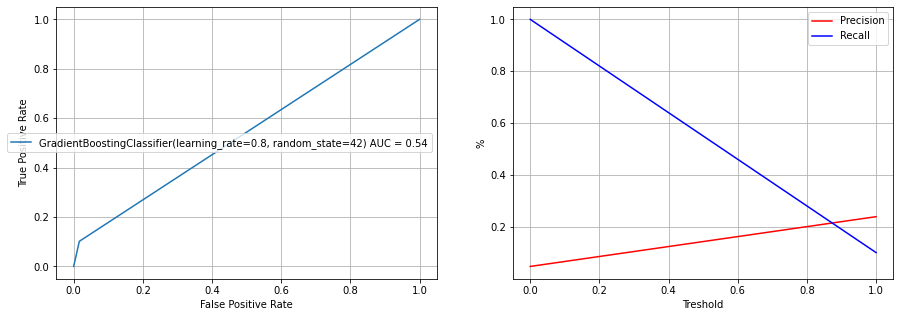


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.50      0.07      0.12        59

    accuracy                           0.95      1220
   macro avg       0.73      0.53      0.55      1220
weighted avg       0.93      0.95      0.93      1220

[[1157    4]
 [  55    4]]


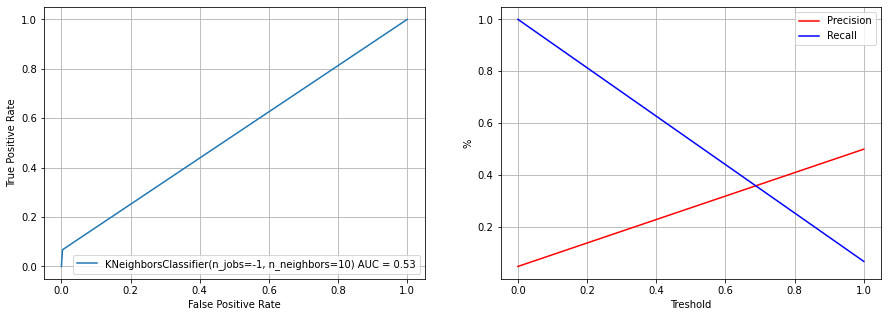


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1161
           1       0.30      0.24      0.26        59

    accuracy                           0.94      1220
   macro avg       0.63      0.60      0.62      1220
weighted avg       0.93      0.94      0.93      1220

[[1128   33]
 [  45   14]]


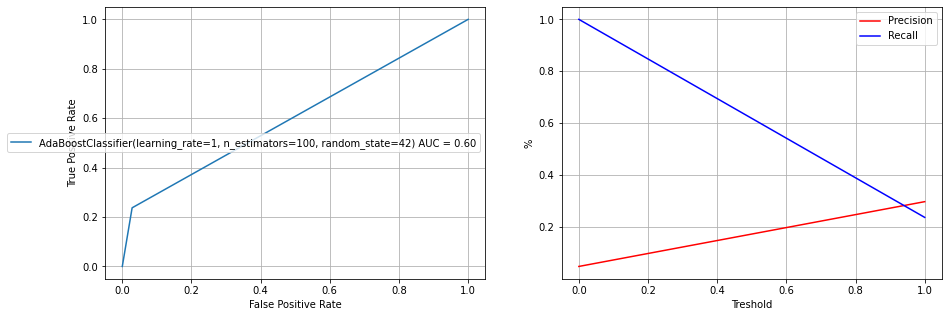


Best Parameters:
 SVC(C=1.2, degree=1, gamma='auto', random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


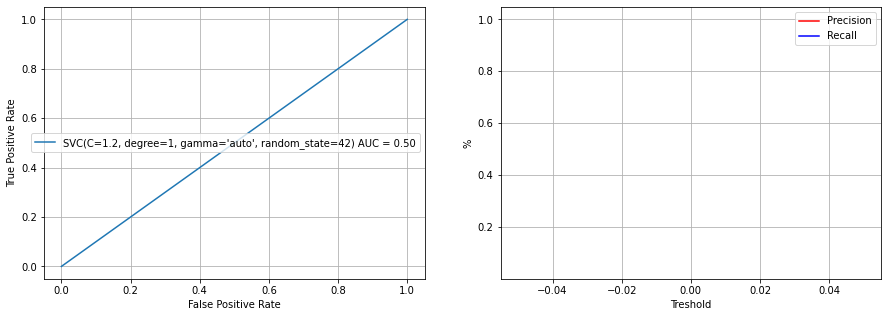


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.12      0.02      0.03        59

    accuracy                           0.95      1220
   macro avg       0.54      0.51      0.50      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  58    1]]


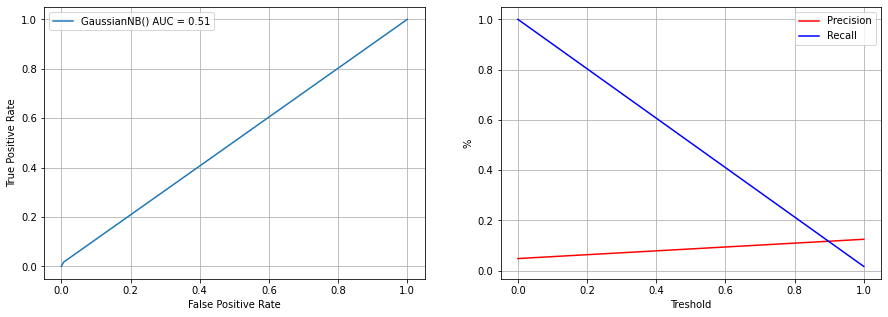


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.19      0.07      0.10        59

    accuracy                           0.94      1220
   macro avg       0.57      0.53      0.53      1220
weighted avg       0.92      0.94      0.93      1220

[[1144   17]
 [  55    4]]


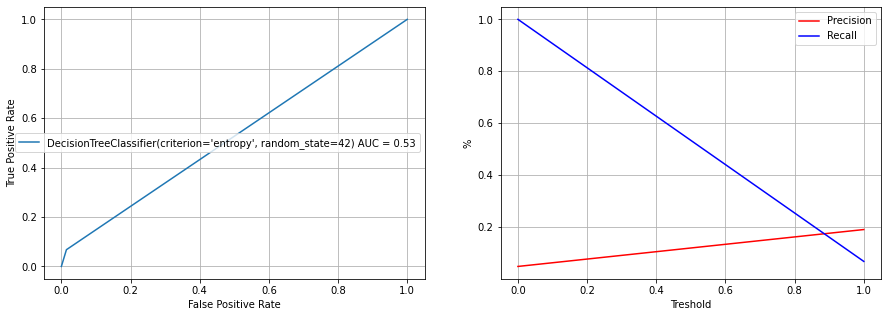

In [51]:
clf_logreg_transf_2, pred_logreg_transf_2 = logreg(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_rfc_transf_2, pred_rfc_transf_2 = rfc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gbc_transf_2, pred_gbc_transf_2 = gbc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_knn_transf_2, pred_knn_transf_2 = knn(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_abc_transf_2, pred_abc_transf_2 = abc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_svc_transf_2, pred_svc_transf_2 = svc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gnb_transf_2, pred_gnb_transf_2 = gnb(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_dtc_transf_2, pred_dtc_transf_2 = dtc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)

## HYDRAULIC

In [52]:
hydraulic_train_2 = hydraulic_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                     'Hyd_Oil_Temp_Avg_sd']]
hydraulic_test_2 = hydraulic_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                   'Hyd_Oil_Temp_Avg_sd']]

In [53]:
# Scale
X_train_hyd_2, X_test_hyd_2 = scale(hydraulic_train_2, hydraulic_test_2)
# X_train_hyd_2 = hydraulic_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_hyd_2 = hydraulic_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [54]:
# Define target and Data Augmentation on training data
y_train_hyd_2 = hydraulic_train['Failure']
y_test_hyd_2 = hydraulic_test['Failure']
X_train_hyd_2, y_train_hyd_2 = data_aug(X_train_hyd_2, y_train_hyd_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1043
           1       0.05      0.02      0.03       177

    accuracy                           0.80      1220
   macro avg       0.45      0.48      0.46      1220
weighted avg       0.73      0.80      0.76      1220

[[968  75]
 [173   4]]


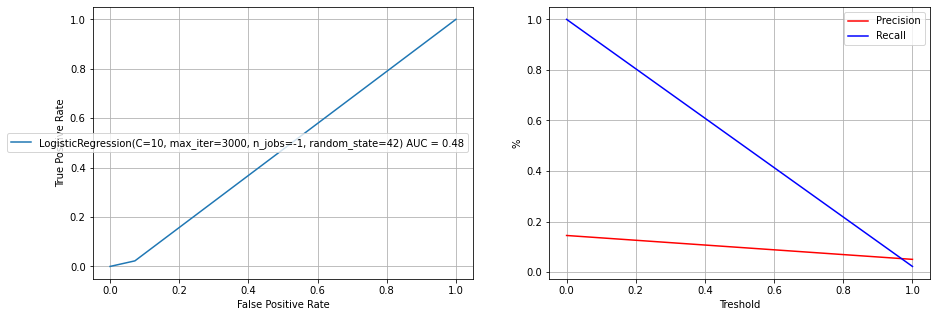


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=500, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1043
           1       0.04      0.01      0.01       177

    accuracy                           0.84      1220
   macro avg       0.45      0.49      0.46      1220
weighted avg       0.74      0.84      0.78      1220

[[1021   22]
 [ 176    1]]


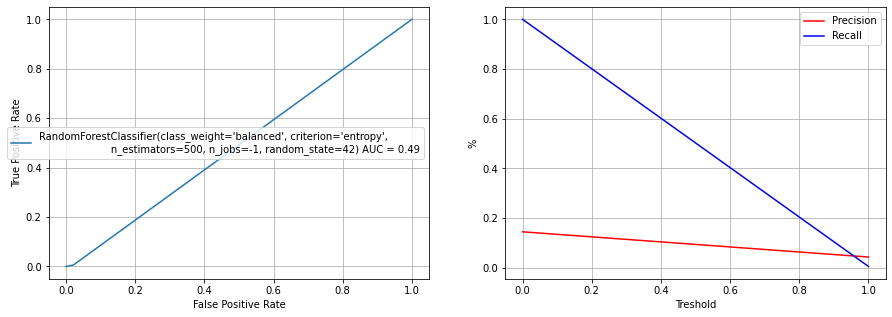


Best Parameters:
 GradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1043
           1       0.05      0.01      0.02       177

    accuracy                           0.82      1220
   macro avg       0.45      0.49      0.46      1220
weighted avg       0.74      0.82      0.78      1220

[[1004   39]
 [ 175    2]]


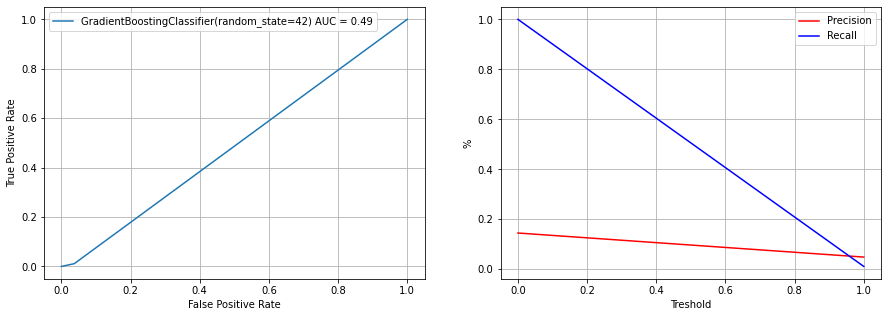


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1043
           1       0.03      0.01      0.01       177

    accuracy                           0.83      1220
   macro avg       0.44      0.49      0.46      1220
weighted avg       0.73      0.83      0.78      1220

[[1013   30]
 [ 176    1]]


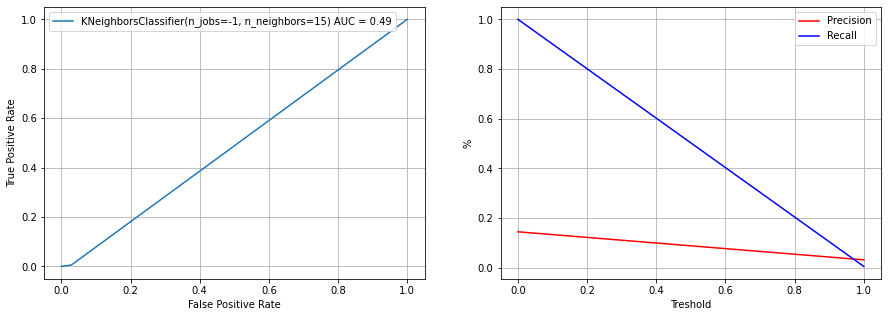


Best Parameters:
 AdaBoostClassifier(learning_rate=0.6, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1043
           1       0.07      0.01      0.02       177

    accuracy                           0.83      1220
   macro avg       0.46      0.49      0.46      1220
weighted avg       0.74      0.83      0.78      1220

[[1016   27]
 [ 175    2]]


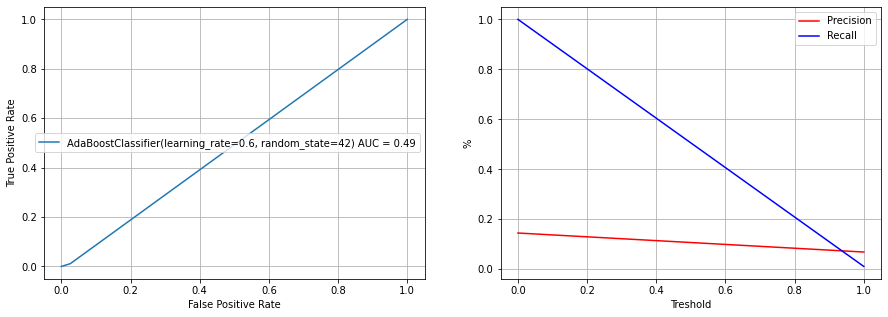


Best Parameters:
 SVC(C=1.2, degree=1, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.84      1220
   macro avg       0.43      0.49      0.46      1220
weighted avg       0.73      0.84      0.78      1220

[[1025   18]
 [ 177    0]]


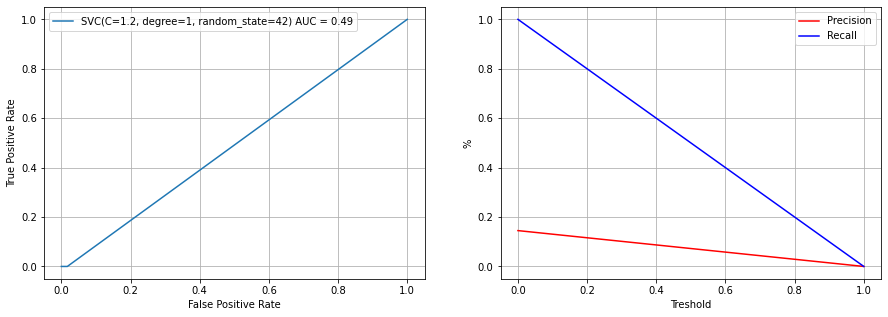


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.85      1220
   macro avg       0.43      0.50      0.46      1220
weighted avg       0.73      0.85      0.79      1220

[[1041    2]
 [ 177    0]]


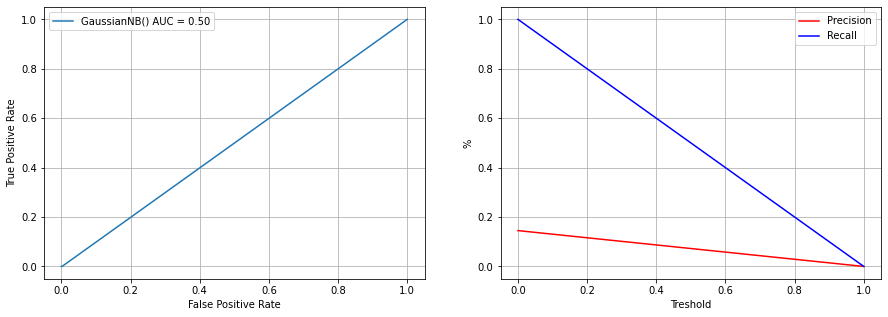


Best Parameters:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1043
           1       0.12      0.04      0.06       177

    accuracy                           0.82      1220
   macro avg       0.49      0.50      0.48      1220
weighted avg       0.75      0.82      0.78      1220

[[993  50]
 [170   7]]


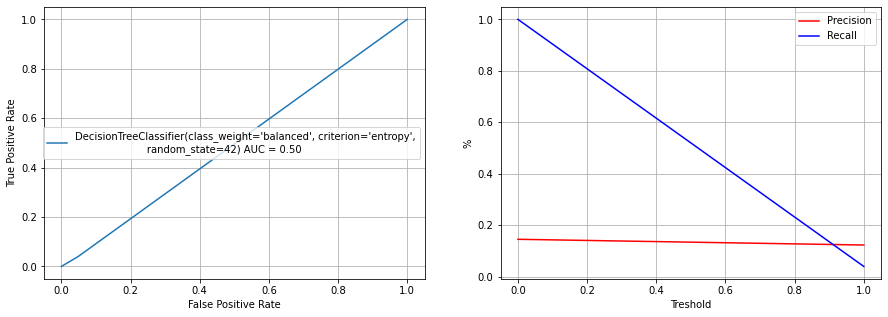

In [55]:
clf_logreg_hyd_2, pred_logreg_hyd_2 = logreg(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_rfc_hyd_2, pred_rfc_hyd_2 = rfc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gbc_hyd_2, pred_gbc_hyd_2 = gbc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_knn_hyd_2, pred_knn_hyd_2 = knn(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_abc_hyd_2, pred_abc_hyd_2 = abc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_svc_hyd_2, pred_svc_hyd_2 = svc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gnb_hyd_2, pred_gnb_hyd_2 = gnb(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_dtc_hyd_2, pred_dtc_hyd_2 = dtc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)

## GEARBOX

In [56]:
gearbox_train_2 = gearbox_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]
gearbox_test_2 = gearbox_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]

In [57]:
# Scale
X_train_gear_2, X_test_gear_2 = scale(gearbox_train_2, gearbox_test_2)
# X_train_gear_2 = gearbox_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_gear_2 = gearbox_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [58]:
# Define target and Data Augmentation on training data
y_train_gear_2 = gearbox_train['Failure']
y_test_gear_2 = gearbox_test['Failure']
X_train_gear_2, y_train_gear_2 = data_aug(X_train_gear_2, y_train_gear_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


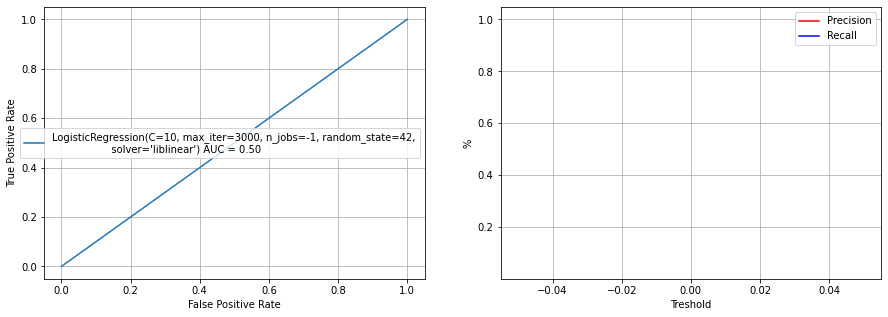


Best Parameters:
 RandomForestClassifier(n_estimators=1200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.91      1212
   macro avg       0.47      0.48      0.48      1212
weighted avg       0.90      0.91      0.91      1212

[[1107   46]
 [  59    0]]


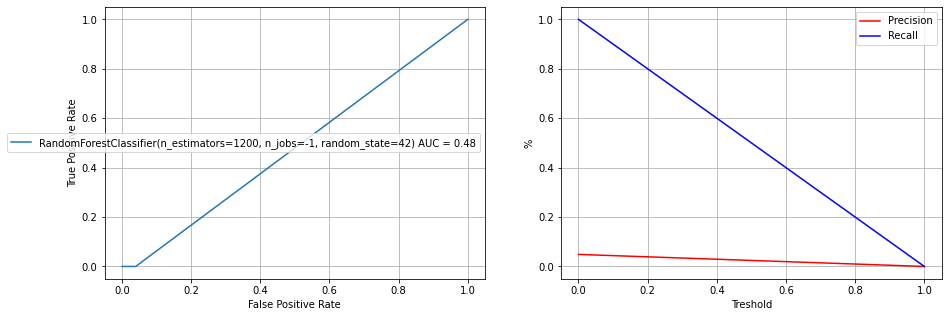


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1153
           1       0.10      0.17      0.12        59

    accuracy                           0.88      1212
   macro avg       0.53      0.54      0.53      1212
weighted avg       0.91      0.88      0.90      1212

[[1058   95]
 [  49   10]]


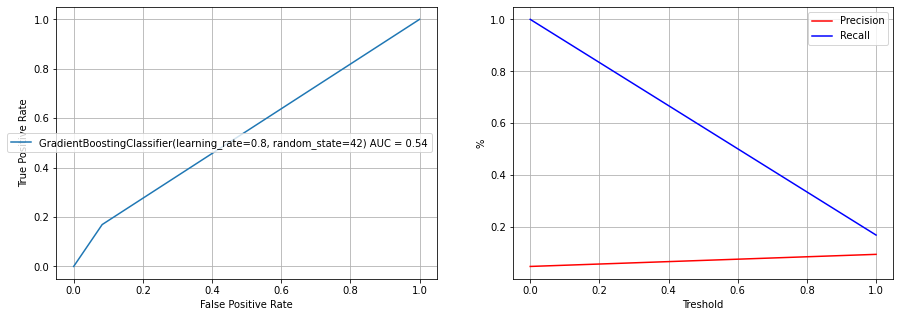


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1153
           1       0.13      0.15      0.14        59

    accuracy                           0.91      1212
   macro avg       0.54      0.55      0.54      1212
weighted avg       0.92      0.91      0.91      1212

[[1091   62]
 [  50    9]]


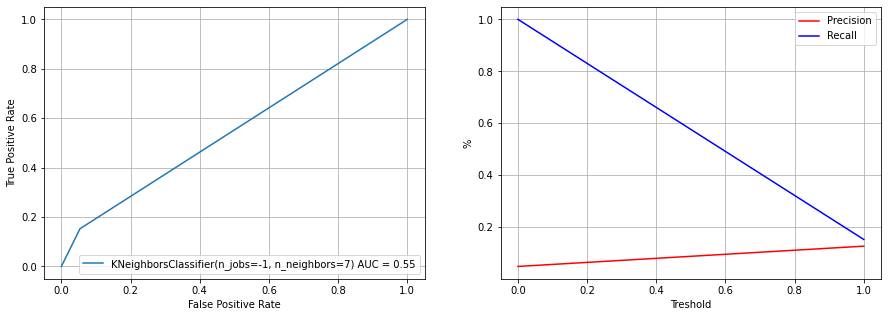


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1153
           1       0.13      0.15      0.14        59

    accuracy                           0.91      1212
   macro avg       0.55      0.55      0.55      1212
weighted avg       0.92      0.91      0.91      1212

[[1095   58]
 [  50    9]]


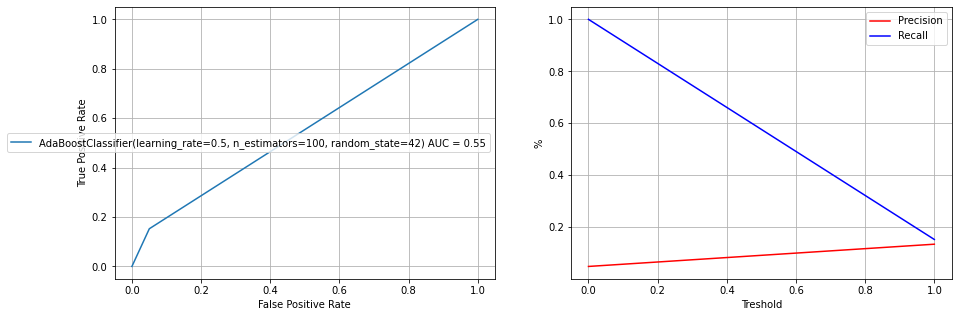


Best Parameters:
 SVC(C=1.2, degree=1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


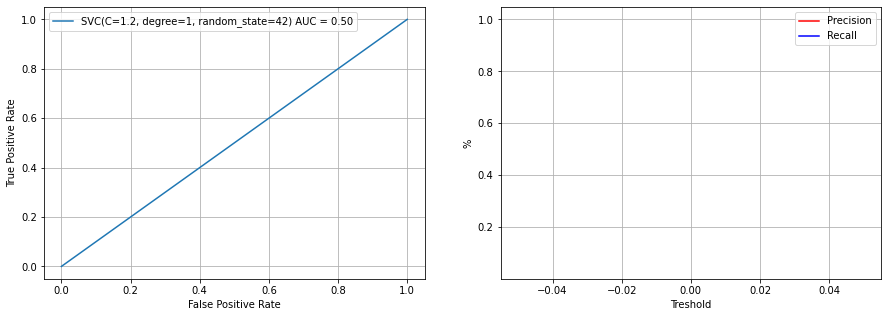


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      1153
           1       0.09      0.39      0.14        59

    accuracy                           0.77      1212
   macro avg       0.52      0.59      0.50      1212
weighted avg       0.92      0.77      0.83      1212

[[906 247]
 [ 36  23]]


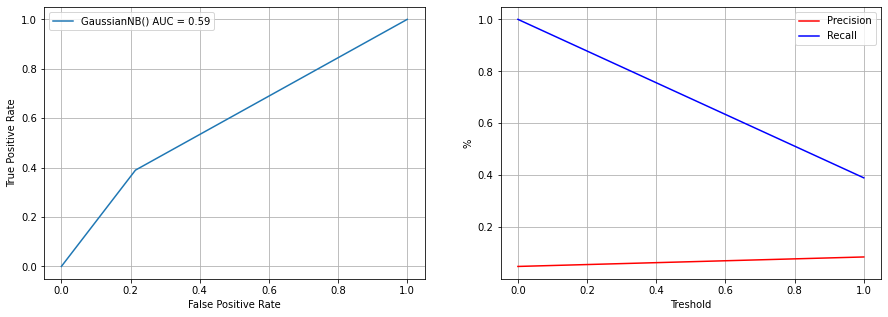


Best Parameters:
 DecisionTreeClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.89      1212
   macro avg       0.47      0.47      0.47      1212
weighted avg       0.90      0.89      0.89      1212

[[1073   80]
 [  59    0]]


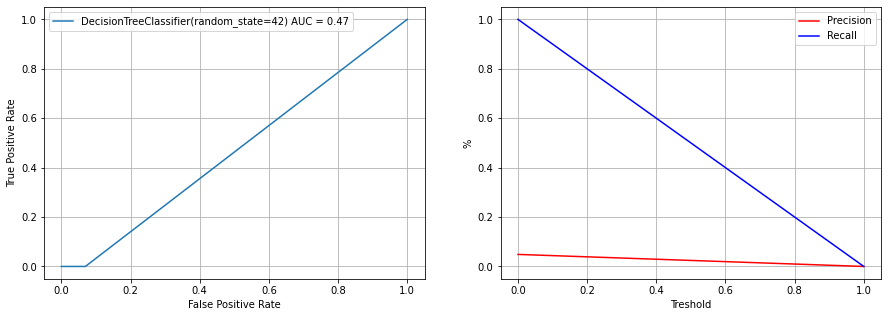

In [59]:
clf_logreg_gear_2, pred_logreg_gear_2 = logreg(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_rfc_gear_2, pred_rfc_gear_2 = rfc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gbc_gear_2, pred_gbc_gear_2 = gbc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_knn_gear_2, pred_knn_gear_2 = knn(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_abc_gear_2, pred_abc_gear_2 = abc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_svc_gear_2, pred_svc_gear_2 = svc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gnb_gear_2, pred_gnb_gear_2 = gnb(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_dtc_gear_2, pred_dtc_gear_2 = dtc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)

## NOTE:

- From now on we will choose the final models. We could fine tune the models in very different ways like different period for rolling aggreggates, more feature engineering (peaks, min, max, median, nº of outliers, etc), different model parameters, new models, different features, retrieve more data, different label, >etc. We could also test regression models (ttf)
- Since this is a first project and we want to proceed to different stages, just for the purpose of learning, We will just define a threshold to decrease the number of the FP and calculate our costs savings
- We do not have a validation set to validate if the models generalize well
- Deploy into production

#### Thresholds
- We will change the default threshold (0.5), according to the business perspective

Text(0.5, 1.0, 'pred_gbc_gen_2')

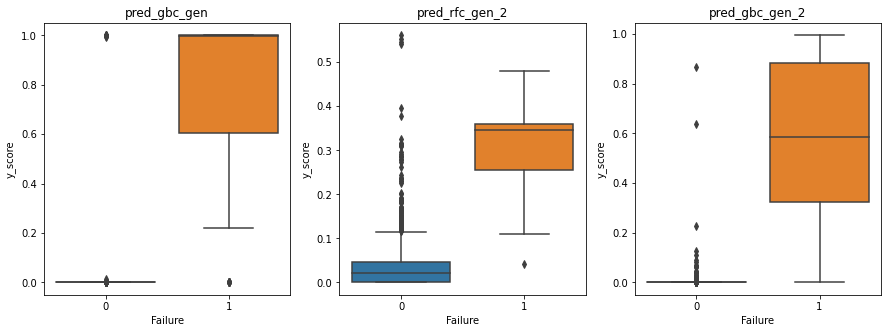

In [60]:
# Generator
plt.figure(figsize=(15,5)) 
plt.subplot(1, 3, 1)
sns.boxplot(x=y_test_gen, y=pred_gbc_gen['y_score'])
plt.title('pred_gbc_gen')
plt.subplot(1, 3, 2)
sns.boxplot(x=y_test_gen_2, y=pred_rfc_gen_2['y_score'])
plt.title('pred_rfc_gen_2')
plt.subplot(1, 3, 3)
sns.boxplot(x=y_test_gen_2, y=pred_gbc_gen_2['y_score'])
plt.title('pred_gbc_gen_2')


Text(0.5, 1.0, 'pred_abc_bear')

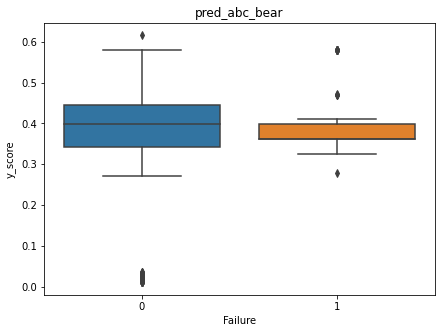

In [61]:
# Generator Bearing
plt.figure(figsize=(7,5)) 
sns.boxplot(x=y_test_bear, y=pred_abc_bear['y_score'])
plt.title('pred_abc_bear')

Text(0.5, 1.0, 'pred_abc_transf_2')

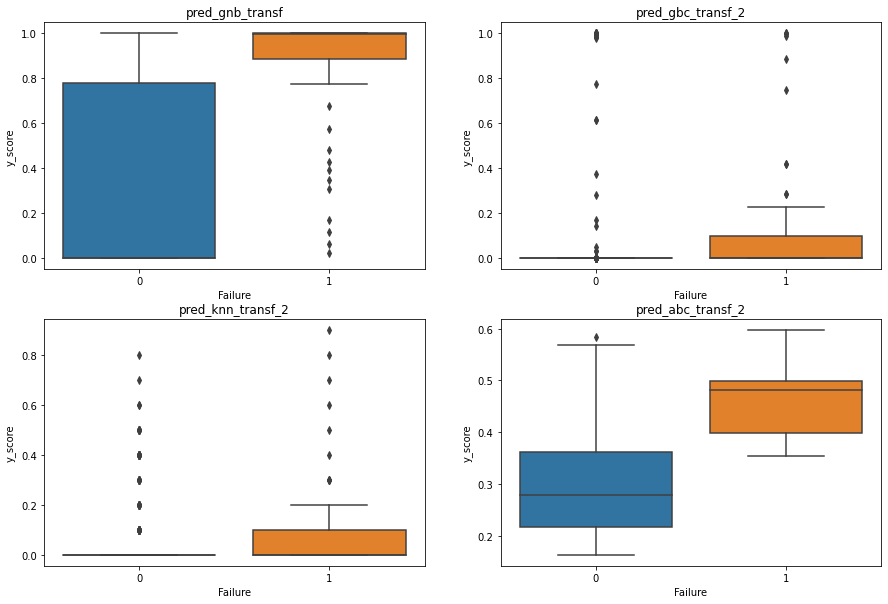

In [62]:
# Transformer
plt.figure(figsize=(15,10)) 
plt.subplot(2, 2, 1)
sns.boxplot(x=y_test_transf, y=pred_gnb_transf['y_score'])
plt.title('pred_gnb_transf')
plt.subplot(2, 2, 2)
sns.boxplot(x=y_test_transf_2, y=pred_gbc_transf_2['y_score'])
plt.title('pred_gbc_transf_2')
plt.subplot(2, 2, 3)
sns.boxplot(x=y_test_transf_2, y=pred_knn_transf_2['y_score'])
plt.title('pred_knn_transf_2')
plt.subplot(2, 2, 4)
sns.boxplot(x=y_test_transf_2, y=pred_abc_transf_2['y_score'])
plt.title('pred_abc_transf_2')

Text(0.5, 1.0, 'pred_gbc_hyd')

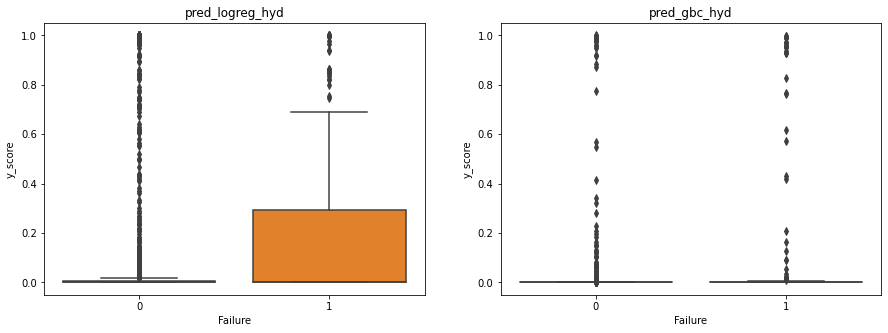

In [78]:
# Hydraulic
plt.figure(figsize=(15,5)) 
plt.subplot(1, 2, 1)
sns.boxplot(x=y_test_hyd, y=pred_logreg_hyd['y_score'])
plt.title('pred_logreg_hyd')
plt.subplot(1, 2, 2)
sns.boxplot(x=y_test_hyd, y=pred_gbc_hyd['y_score'])
plt.title('pred_gbc_hyd')

Text(0.5, 1.0, 'pred_gnb_gear_2')

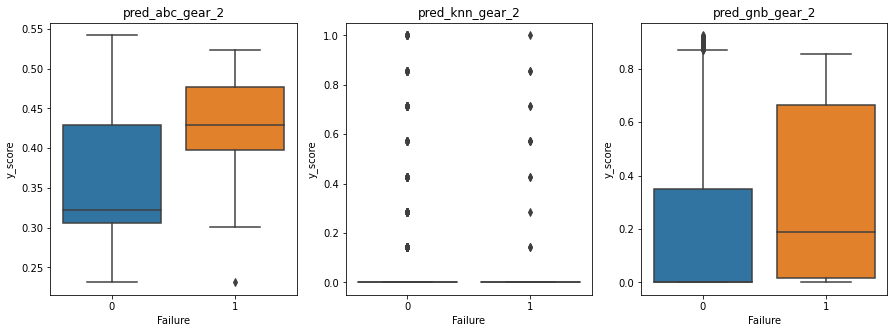

In [64]:
# Gearbox
plt.figure(figsize=(15,5)) 
plt.subplot(1, 3, 1)
sns.boxplot(x=y_test_gear_2, y=pred_abc_gear_2['y_score'])
plt.title('pred_abc_gear_2')
plt.subplot(1, 3, 2)
sns.boxplot(x=y_test_gear_2, y=pred_knn_gear_2['y_score'])
plt.title('pred_knn_gear_2')
plt.subplot(1, 3, 3)
sns.boxplot(x=y_test_gear_2, y=pred_gnb_gear_2['y_score'])
plt.title('pred_gnb_gear_2')

### From a business prespective, we will assume that we send a technical repair employee only with 20 days interval. So, if our model predicts a failure in day 1 and day 15, the employee will only go 1 time to run diagnosis/repair on the turbine

######  Create new Dataframes to study the costs from a business perspective

In [65]:
df_costs

,Component,Replacement_Cost,Repair_Cost,Inspection_cost
0,GEARBOX,100000,20000,5000
1,GENERATOR,60000,15000,5000
2,GENERATOR_BEARING,30000,12500,4500
3,TRANSFORMER,50000,3500,1500
4,HYDRAULIC_GROUP,20000,3000,2000


In [66]:
def threshold(df, algo, trsh=0.5):
    '''Function to apply a threshold to try to minimize FP and improve costs savings
    
    Args:
            df                 : dataframe to apply
            algo               : model chosed
        
    Returns:
            df_costs           : a data frame with a new y_pred column for the chosen threshold'''
    
    # Concat with "True Failure" for Gradient Boosting Algo
    df_costs = pd.concat([algo, df[['Turbine_ID', 'Date', 'TTF', 'Failure']]], axis=1)
    # Create a Column with a cutoff of 0.6 
    df_costs['y_trsh'] = np.where(((df_costs['y_score'] <= trsh)), 0, 1)
    
    return df_costs

In [67]:
def pos_neg(df, days=20):
    
    '''Function to apply financial engineering'''
    
    df['TP'] = 0 # True positives
    df['FN'] = 0 # False Negatives
    df['FP'] = 0 # False Positives
    df['GO'] = 0 # An employee go
    # True Positives
    df['TP'] = df.apply(lambda x: 1 if x['y_trsh'] == 1 and x['Failure'] == 1 else x['TP'], axis = 1)
    # False Positives
    df['FP'] = df.apply(lambda x: 1 if x['y_trsh'] == 1 and x['Failure'] == 0 else x['FP'], axis = 1)
    # False Negatives
    df['FN'] = df.apply(lambda x: 1 if x['y_trsh'] == 0 and x['Failure'] == 1 else x['FN'], axis = 1)
    # Aux column for the 20 days interval
    for i, (tp, fp) in enumerate(zip(df['TP'], df['FP'])):
        if tp == 1 or fp == 1: # Find the first FP or TP
            df['GO'][i] = 1
            break
    #From 20 to 20 days flag as 1
    i = df.index[df['GO'] == 1]
    df.iloc[i[0]::days, :]['GO'] = 1
    
    return df

In [68]:
def mat_cost(df, component):
    
    '''Function to calculate final costs savings for each component'''
    
    # Aux Variables
    count_fn = 0
    count_fp = 0
    tp_cost = 0
    aux_date = None
    aux_turbine = None
    
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Financial Engineering
    for i, (tp, fn, fp, go) in enumerate(zip(df['TP'], df['FN'], df['FP'], df['GO'])):
        if component == 'Gearbox':
            if tp == 1 and go == 1:
                cost = df_costs.loc[0, 'Replacement_Cost']-(df_costs.loc[0, 'Repair_Cost']+
                                    (df_costs.loc[0, 'Replacement_Cost']-df_costs.loc[0, 'Repair_Cost'])*(1-df['TTF'][i]/60))
                if aux_date is None: # If there is a TP, not count FN or other TP until failure
                    tp_cost += cost
                    aux_date = df['Date'][i]
                    aux_turbine = df['Turbine_ID'][i]
                else:
                    if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: #label between 2-60 days
                        pass
                    else:
                        tp_cost += cost
                        aux_date = df['Date'][i]
                        aux_turbine = df['Turbine_ID'][i]
                
            elif fn == 1 and go == 1:
                if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: #label between 2-60 days
                    pass
                else:
                    count_fn += 1

            elif fp == 1 and go == 1:
                count_fp += 1

            fn_cost = df_costs.loc[0, 'Replacement_Cost']*count_fn
            fp_cost = df_costs.loc[0, 'Inspection_cost']*count_fp
            
        
        if component == 'Generator':
            if tp == 1 and go == 1:
                cost = df_costs.loc[1, 'Replacement_Cost']-(df_costs.loc[1, 'Repair_Cost']+
                                    (df_costs.loc[1, 'Replacement_Cost']-df_costs.loc[1, 'Repair_Cost'])*(1-df['TTF'][i]/60))
                if aux_date is None: # If there is a TP, not count FN or other TP until failure
                    tp_cost += cost
                    aux_date = df['Date'][i]
                    aux_turbine = df['Turbine_ID'][i]
                else:
                    if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: 
                        pass
                    else:
                        tp_cost += cost
                        aux_date = df['Date'][i]
                        aux_turbine = df['Turbine_ID'][i]
                
            elif fn == 1 and go == 1:
                if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58:
                    pass
                else:
                    count_fn += 1

            elif fp == 1 and go == 1:
                count_fp += 1

            fn_cost = df_costs.loc[1, 'Replacement_Cost']*count_fn
            fp_cost = df_costs.loc[1, 'Inspection_cost']*count_fp
            
            
        if component == 'Generator Bearing':
            if tp == 1 and go == 1:
                cost = df_costs.loc[2, 'Replacement_Cost']-(df_costs.loc[2, 'Repair_Cost']+
                                    (df_costs.loc[2, 'Replacement_Cost']-df_costs.loc[2, 'Repair_Cost'])*(1-df['TTF'][i]/60))
                if aux_date is None: # If there is a TP, not count FN or other TP until failure
                    tp_cost += cost
                    aux_date = df['Date'][i]
                    aux_turbine = df['Turbine_ID'][i]
                else:
                    if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: 
                        pass
                    else:
                        tp_cost += cost
                        aux_date = df['Date'][i]
                        aux_turbine = df['Turbine_ID'][i]
                
                
            elif fn == 1 and go == 1:
                if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58:
                    pass
                else:
                    count_fn += 1

            elif fp == 1 and go == 1:
                count_fp += 1

            fn_cost = df_costs.loc[2, 'Replacement_Cost']*count_fn
            fp_cost = df_costs.loc[2, 'Inspection_cost']*count_fp
            
        if component == 'Transformer':
            if tp == 1 and go == 1:
                cost = df_costs.loc[3, 'Replacement_Cost']-(df_costs.loc[3, 'Repair_Cost']+
                                    (df_costs.loc[3, 'Replacement_Cost']-df_costs.loc[3, 'Repair_Cost'])*(1-df['TTF'][i]/60))
                if aux_date is None: # If there is a TP, not count FN or other TP until failure
                    tp_cost += cost
                    aux_date = df['Date'][i]
                    aux_turbine = df['Turbine_ID'][i]
                else:
                    if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: 
                        pass
                    else:
                        tp_cost += cost
                        aux_date = df['Date'][i]
                        aux_turbine = df['Turbine_ID'][i]
                
            elif fn == 1 and go == 1:
                if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58:
                    pass
                else:
                    count_fn += 1

            elif fp == 1 and go == 1:
                count_fp += 1

            fn_cost = df_costs.loc[3, 'Replacement_Cost']*count_fn
            fp_cost = df_costs.loc[3, 'Inspection_cost']*count_fp
            

            
        if component == 'Hydraulic':
            if tp == 1 and go == 1:
                cost = df_costs.loc[4, 'Replacement_Cost']-(df_costs.loc[4, 'Repair_Cost']+
                                    (df_costs.loc[4, 'Replacement_Cost']-df_costs.loc[4, 'Repair_Cost'])*(1-df['TTF'][i]/60))
                if aux_date is None: # If there is a TP, not count FN or other TP until failure
                    tp_cost += cost
                    aux_date = df['Date'][i]
                    aux_turbine = df['Turbine_ID'][i]
                else:
                    if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58: 
                        pass
                    else:
                        tp_cost += cost
                        aux_date = df['Date'][i]
                        aux_turbine = df['Turbine_ID'][i]
                
            elif fn == 1 and go == 1:
                if df['Turbine_ID'][i] == aux_turbine and ((df['Date'][i] - aux_date)).days<58:
                    pass
                else:
                    count_fn += 1

            elif fp == 1 and go == 1:
                count_fp += 1

            fn_cost = df_costs.loc[4, 'Replacement_Cost']*count_fn
            fp_cost = df_costs.loc[4, 'Inspection_cost']*count_fp
            
           
        savings = tp_cost - fn_cost - fp_cost
    
    return savings
    

#### Generator

In [69]:
generator_costs = threshold(generator_test, pred_gbc_gen, 0.6)
generator_costs = pos_neg(generator_costs)
generator_savings = mat_cost(generator_costs, 'Generator')
generator_savings

34000.0

#### Generator Bearing

In [82]:
gen_bear_costs = threshold(gen_bear_test, pred_abc_bear, 0.6)
gen_bear_costs = pos_neg(gen_bear_costs)
gen_bear_savings = mat_cost(gen_bear_costs, 'Generator Bearing')
gen_bear_savings

-4500

#### Transformer

In [71]:
transf_costs = threshold(transformer_test, pred_gnb_transf, 0.75)
transf_costs = pos_neg(transf_costs)
transf_savings = mat_cost(transf_costs, 'Transformer')
transf_savings

10050.0

#### Hydraulic

In [86]:
hyd_costs = threshold(hydraulic_test, pred_gbc_hyd, 0.3)
hyd_costs = pos_neg(hyd_costs)
hyd_savings = mat_cost(hyd_costs, 'Hydraulic')
hyd_savings

-136650.0

#### Gearbox

In [84]:
gear_costs = threshold(gearbox_test, pred_abc_gear_2, 0.52)
gear_costs = pos_neg(gear_costs)
gear_savings = mat_cost(gear_costs, 'Gearbox')
gear_savings

25666.666666666657

## Comparison between having the models and not 

In [87]:
# Failures in test period
generator_wm = 1
gen_bear_wm = 2
transf_wm = 1
hyd_wm = 3
gearbox_wm = 1

In [88]:
gen_cost_wm = - generator_wm * df_costs.loc[1, 'Replacement_Cost']
gen_bear_cost_wm = - gen_bear_wm * df_costs.loc[2, 'Replacement_Cost']
transf_cost_wm = - transf_wm * df_costs.loc[3, 'Replacement_Cost']
hyd_cost_wm = - hyd_wm * df_costs.loc[4, 'Replacement_Cost']
gearbox_cost_wm = - gearbox_wm * df_costs.loc[0, 'Replacement_Cost']

In [89]:
# Dataframe for comparison
r = {
        "Without Model": pd.Series([gen_cost_wm, gen_bear_cost_wm, transf_cost_wm, hyd_cost_wm, gearbox_cost_wm], 
                                   index=["Generator", "Generator Bearing", "Transformer", "Hydraulic", "Gearbox"]),
        "With Model": pd.Series([generator_savings, gen_bear_savings, transf_savings, hyd_savings, gear_savings], 
                                index=["Generator", "Generator Bearing", "Transformer", "Hydraulic", "Gearbox"])
   }
resume = pd.DataFrame(r)
resume

,Without Model,With Model
Generator,-60000,34000.000000
Generator Bearing,-60000,-4500.000000
Transformer,-50000,10050.000000
Hydraulic,-60000,-136650.000000
Gearbox,-100000,25666.666667


##### Definetly improve Gen Bear and Hydraulic Models. And also the others

# Future Work
- Train a NN and evaluate
- Improve Models of Generator Bearing and Hydraulic Components
- Retrieve more data, for separate into train, validation and test
- Train models with the custom cost function of the costs
- Better feature engineering and data preparation
- Iterate through more options within algorithms, data, etc